In [1]:
# Import Libraries and Setup Directories

# Standard Library
import datetime as dt
import itertools
import json
import logging
import os
import pickle
import subprocess
import sys
import time
import warnings
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple

# Third-party Libraries - Data Handling and Numerical Computing
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# Machine Learning and Statistical Analysis
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, 
                                   GRU, Input, LSTM, LayerNormalization, 
                                   SimpleRNN)
from tensorflow.keras.models import Sequential, load_model

# Financial Data
import pandas_datareader as web
import yfinance as yf

# Sentiment Analysis and Web Scraping
import requests
import yaml
from dotenv import load_dotenv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Configuration
warnings.filterwarnings('ignore')

# Ensure necessary directories exist
DATA_DIR = "data"
MODEL_DIR = "models"
for directory in [DATA_DIR, MODEL_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'{DATA_DIR}/stock_prediction.log'),
        logging.StreamHandler()
    ]
)

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:


# Load environment variables
load_dotenv()

# Create sentiment cache directory
SENTIMENT_CACHE_DIR = "data/sentiment_cache"
if not os.path.exists(SENTIMENT_CACHE_DIR):
    os.makedirs(SENTIMENT_CACHE_DIR)
    print(f"Created directory: {SENTIMENT_CACHE_DIR}")

@dataclass
class SentimentScore:
    """Data class for sentiment scores"""
    compound: float  # Overall sentiment (-1 to 1)
    positive: float  # Positive component (0 to 1)
    negative: float  # Negative component (0 to 1)
    neutral: float   # Neutral component (0 to 1)
    confidence: float = 1.0  # Confidence in the score (0 to 1)

@dataclass
class NewsArticle:
    """Data class for news articles"""
    title: str
    content: str
    published_at: datetime
    source: str
    url: str
    relevance_score: float = 1.0

@dataclass
class SocialPost:
    """Data class for social media posts"""
    text: str
    created_at: datetime
    platform: str
    author: str
    engagement_metrics: dict
    is_spam: bool = False

@dataclass
class SentimentConfig:
    """Configuration for sentiment analysis"""
    enabled: bool = True
    news_sources: List[str] = field(default_factory=lambda: ['newsapi'])
    social_platforms: List[str] = field(default_factory=lambda: ['twitter'])
    sentiment_analyzer: str = 'vader'
    cache_duration_hours: int = 24
    max_articles_per_day: int = 50
    max_posts_per_day: int = 100

# Custom exceptions
class SentimentAnalysisError(Exception):
    """Base exception for sentiment analysis errors"""
    pass

class APIRateLimitError(SentimentAnalysisError):
    """Raised when API rate limits are exceeded"""
    pass

class DataQualityError(SentimentAnalysisError):
    """Raised when sentiment data quality is poor"""
    pass

print("✅ Sentiment analysis infrastructure setup complete!")

Created directory: data/sentiment_cache
✅ Sentiment analysis infrastructure setup complete!


In [3]:
# Sentiment Analyzer Implementation
class SentimentAnalyzer:
    """Processes text content to extract sentiment scores"""
    
    def __init__(self, analyzer_type: str = 'vader'):
        self.analyzer_type = analyzer_type
        if analyzer_type == 'vader':
            self.analyzer = SentimentIntensityAnalyzer()
        else:
            raise ValueError(f"Unsupported analyzer type: {analyzer_type}")
    
    def _preprocess_text(self, text: str) -> str:
        """Preprocess text for financial sentiment analysis"""
        if not text:
            return ""
        
        # Basic cleaning
        text = text.strip()
        # Remove excessive whitespace
        text = ' '.join(text.split())
        return text
    
    def analyze_text(self, text: str) -> SentimentScore:
        """Analyze sentiment of a single text"""
        try:
            processed_text = self._preprocess_text(text)
            if not processed_text:
                return SentimentScore(0.0, 0.0, 0.0, 1.0, 0.0)
            
            scores = self.analyzer.polarity_scores(processed_text)
            return SentimentScore(
                compound=scores['compound'],
                positive=scores['pos'],
                negative=scores['neg'],
                neutral=scores['neu'],
                confidence=1.0
            )
        except Exception as e:
            logging.error(f"Error analyzing text sentiment: {e}")
            return SentimentScore(0.0, 0.0, 0.0, 1.0, 0.0)
    
    def batch_analyze(self, texts: List[str]) -> List[SentimentScore]:
        """Analyze sentiment of multiple texts"""
        return [self.analyze_text(text) for text in texts]

print("✅ SentimentAnalyzer class implemented!")

✅ SentimentAnalyzer class implemented!


In [4]:
# News API Client Implementation
class NewsAPIClient:
    """Fetches news articles from external APIs"""
    
    def __init__(self, api_key: str = None, base_url: str = "https://newsapi.org/v2"):
        self.api_key = api_key or os.getenv('NEWS_API_KEY')
        self.base_url = base_url
        self.session = requests.Session()
        if self.api_key:
            self.session.headers.update({'X-API-Key': self.api_key})
    
    def _build_query(self, symbol: str) -> str:
        """Build search query for company news"""
        company_queries = {
            'CBA.AX': 'Commonwealth Bank OR CBA OR "Commonwealth Bank of Australia"',
        }
        return company_queries.get(symbol, symbol.replace('.', ' '))
    
    def _handle_rate_limits(self, response) -> None:
        """Handle API rate limiting"""
        if response.status_code == 429:
            retry_after = int(response.headers.get('Retry-After', 60))
            logging.warning(f"Rate limit hit, waiting {retry_after} seconds")
            time.sleep(retry_after)
            raise APIRateLimitError("Rate limit exceeded")
    
    def fetch_news(self, query: str, from_date: str, to_date: str) -> List[NewsArticle]:
        """Fetch news articles for given query and date range"""
        if not self.api_key:
            logging.warning("No News API key provided, using mock data")
            return self._get_mock_news(query, from_date, to_date)
        
        try:
            params = {
                'q': query,
                'from': from_date,
                'to': to_date,
                'sortBy': 'publishedAt',
                'language': 'en',
                'pageSize': 50
            }
            
            response = self.session.get(f"{self.base_url}/everything", params=params)
            self._handle_rate_limits(response)
            response.raise_for_status()
            
            data = response.json()
            articles = []
            
            for article_data in data.get('articles', []):
                try:
                    article = NewsArticle(
                        title=article_data.get('title', ''),
                        content=article_data.get('description', '') or article_data.get('content', ''),
                        published_at=datetime.fromisoformat(article_data['publishedAt'].replace('Z', '+00:00')),
                        source=article_data.get('source', {}).get('name', 'Unknown'),
                        url=article_data.get('url', ''),
                        relevance_score=1.0
                    )
                    articles.append(article)
                except Exception as e:
                    logging.warning(f"Error parsing article: {e}")
                    continue
            
            return articles
            
        except Exception as e:
            logging.error(f"Error fetching news: {e}")
            return self._get_mock_news(query, from_date, to_date)
    
    def _get_mock_news(self, query: str, from_date: str, to_date: str) -> List[NewsArticle]:
        """Generate mock news data for testing"""
        mock_articles = [
            NewsArticle(
                title=f"Commonwealth Bank reports strong quarterly results",
                content="Commonwealth Bank announced strong financial performance with increased profits and customer growth.",
                published_at=datetime.strptime(from_date, '%Y-%m-%d') + timedelta(days=1),
                source="Financial Review",
                url="https://example.com/news1",
                relevance_score=0.9
            ),
            NewsArticle(
                title=f"CBA faces regulatory scrutiny over lending practices",
                content="Banking regulator announces investigation into Commonwealth Bank's lending procedures.",
                published_at=datetime.strptime(from_date, '%Y-%m-%d') + timedelta(days=2),
                source="ABC News",
                url="https://example.com/news2",
                relevance_score=0.8
            )
        ]
        return mock_articles

print("✅ NewsAPIClient class implemented!")

✅ NewsAPIClient class implemented!


In [5]:
# Social Media Client Implementation
class SocialMediaClient:
    """Collects social media posts mentioning the target company"""
    
    def __init__(self, platform: str = 'twitter', credentials: dict = None):
        self.platform = platform
        self.credentials = credentials or {}
    
    def _filter_relevant_posts(self, posts: List[SocialPost]) -> List[SocialPost]:
        """Filter posts for relevance to financial topics"""
        financial_keywords = ['stock', 'price', 'earnings', 'profit', 'loss', 'dividend', 'market', 'trading']
        relevant_posts = []
        
        for post in posts:
            text_lower = post.text.lower()
            if any(keyword in text_lower for keyword in financial_keywords):
                relevant_posts.append(post)
        
        return relevant_posts
    
    def _detect_spam(self, post: SocialPost) -> bool:
        """Simple spam detection"""
        spam_indicators = ['buy now', 'guaranteed profit', 'risk free', 'get rich quick']
        text_lower = post.text.lower()
        return any(indicator in text_lower for indicator in spam_indicators)
    
    def fetch_posts(self, query: str, start_date: str, end_date: str) -> List[SocialPost]:
        """Fetch social media posts for given query and date range"""
        # For now, return mock data since we don't have API access
        return self._get_mock_posts(query, start_date, end_date)
    
    def _get_mock_posts(self, query: str, start_date: str, end_date: str) -> List[SocialPost]:
        """Generate mock social media posts for testing"""
        mock_posts = [
            SocialPost(
                text="CBA stock looking strong today! Great earnings report 📈",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=1),
                platform="twitter",
                author="investor123",
                engagement_metrics={"likes": 45, "retweets": 12},
                is_spam=False
            ),
            SocialPost(
                text="Not happy with Commonwealth Bank's latest fees increase 😠",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=2),
                platform="twitter",
                author="customer456",
                engagement_metrics={"likes": 23, "retweets": 8},
                is_spam=False
            ),
            SocialPost(
                text="CBA dividend announcement coming soon. Expecting good results!",
                created_at=datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=3),
                platform="twitter",
                author="trader789",
                engagement_metrics={"likes": 67, "retweets": 15},
                is_spam=False
            )
        ]
        
        # Filter for relevance and spam
        relevant_posts = self._filter_relevant_posts(mock_posts)
        clean_posts = [post for post in relevant_posts if not self._detect_spam(post)]
        
        return clean_posts

print("✅ SocialMediaClient class implemented!")

✅ SocialMediaClient class implemented!


In [6]:
# Sentiment Data Collector Implementation
class SentimentDataCollector:
    """Orchestrates collection of sentiment data from multiple sources"""
    
    def __init__(self, config: SentimentConfig):
        self.config = config
        self.sentiment_analyzer = SentimentAnalyzer(config.sentiment_analyzer)
        self.news_client = NewsAPIClient()
        self.social_client = SocialMediaClient()
    
    def get_cached_data(self, symbol: str, date_range: tuple) -> Optional[pd.DataFrame]:
        """Check for cached sentiment data"""
        start_date, end_date = date_range
        cache_file = f"{SENTIMENT_CACHE_DIR}/{symbol}_{start_date}_{end_date}_sentiment.csv"
        
        if os.path.exists(cache_file):
            # Check if cache is still valid
            file_age = time.time() - os.path.getmtime(cache_file)
            if file_age < (self.config.cache_duration_hours * 3600):
                try:
                    df = pd.read_csv(cache_file)
                    df['Date'] = pd.to_datetime(df['Date'])
                    logging.info(f"Using cached sentiment data for {symbol}")
                    return df
                except Exception as e:
                    logging.warning(f"Error reading cache file: {e}")
        
        return None
    
    def save_to_cache(self, data: pd.DataFrame, symbol: str, date_range: tuple) -> None:
        """Save sentiment data to cache"""
        start_date, end_date = date_range
        cache_file = f"{SENTIMENT_CACHE_DIR}/{symbol}_{start_date}_{end_date}_sentiment.csv"
        
        try:
            data.to_csv(cache_file, index=False)
            logging.info(f"Sentiment data cached to {cache_file}")
        except Exception as e:
            logging.error(f"Error saving to cache: {e}")
    
    def _merge_sources(self, news_sentiment: pd.DataFrame, social_sentiment: pd.DataFrame) -> pd.DataFrame:
        """Combine news and social media sentiment"""
        # Merge on date, using outer join to keep all dates
        merged = pd.merge(news_sentiment, social_sentiment, on='Date', how='outer', suffixes=('_news', '_social'))
        
        # Calculate combined sentiment (weighted average)
        news_weight = 0.6  # News typically more reliable
        social_weight = 0.4
        
        merged['sentiment_compound'] = (
            merged['sentiment_compound_news'].fillna(0) * news_weight +
            merged['sentiment_compound_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_positive'] = (
            merged['sentiment_positive_news'].fillna(0) * news_weight +
            merged['sentiment_positive_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_negative'] = (
            merged['sentiment_negative_news'].fillna(0) * news_weight +
            merged['sentiment_negative_social'].fillna(0) * social_weight
        )
        
        merged['sentiment_neutral'] = (
            merged['sentiment_neutral_news'].fillna(1) * news_weight +
            merged['sentiment_neutral_social'].fillna(1) * social_weight
        )
        
        # Add volume metrics
        merged['news_volume'] = merged['news_volume'].fillna(0)
        merged['social_volume'] = merged['social_volume'].fillna(0)
        merged['total_volume'] = merged['news_volume'] + merged['social_volume']
        
        # Select final columns
        final_columns = ['Date', 'sentiment_compound', 'sentiment_positive', 'sentiment_negative', 
                        'sentiment_neutral', 'news_volume', 'social_volume', 'total_volume']
        
        return merged[final_columns]
    
    def _handle_missing_dates(self, sentiment_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
        """Fill gaps in sentiment data"""
        # Create complete date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        complete_df = pd.DataFrame({'Date': date_range})
        
        # Merge with sentiment data
        merged = pd.merge(complete_df, sentiment_df, on='Date', how='left')
        
        # Forward fill sentiment scores
        sentiment_columns = ['sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral']
        for col in sentiment_columns:
            merged[col] = merged[col].fillna(method='ffill').fillna(0.0)
        
        # Fill volume with 0
        volume_columns = ['news_volume', 'social_volume', 'total_volume']
        for col in volume_columns:
            merged[col] = merged[col].fillna(0)
        
        return merged
    
    def collect_sentiment_data(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Main entry point for sentiment collection"""
        if not self.config.enabled:
            logging.info("Sentiment analysis disabled, returning neutral sentiment")
            return self._create_neutral_sentiment(start_date, end_date)
        
        date_range = (start_date, end_date)
        
        # Check cache first
        cached_data = self.get_cached_data(symbol, date_range)
        if cached_data is not None:
            return cached_data
        
        logging.info(f"Collecting sentiment data for {symbol} from {start_date} to {end_date}")
        
        try:
            # Collect news sentiment
            news_sentiment = self._collect_news_sentiment(symbol, start_date, end_date)
            
            # Collect social media sentiment
            social_sentiment = self._collect_social_sentiment(symbol, start_date, end_date)
            
            # Merge sources
            combined_sentiment = self._merge_sources(news_sentiment, social_sentiment)
            
            # Handle missing dates
            final_sentiment = self._handle_missing_dates(combined_sentiment, start_date, end_date)
            
            # Cache the results
            self.save_to_cache(final_sentiment, symbol, date_range)
            
            return final_sentiment
            
        except Exception as e:
            logging.error(f"Error collecting sentiment data: {e}")
            return self._create_neutral_sentiment(start_date, end_date)
    
    def _collect_news_sentiment(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Collect and analyze news sentiment"""
        query = self.news_client._build_query(symbol)
        articles = self.news_client.fetch_news(query, start_date, end_date)
        
        if not articles:
            return self._create_empty_sentiment_df()
        
        # Analyze sentiment for each article
        daily_sentiment = {}
        
        for article in articles:
            date_key = article.published_at.date()
            text = f"{article.title} {article.content}"
            sentiment = self.sentiment_analyzer.analyze_text(text)
            
            if date_key not in daily_sentiment:
                daily_sentiment[date_key] = []
            
            daily_sentiment[date_key].append(sentiment)
        
        # Aggregate daily sentiment
        sentiment_data = []
        for date, sentiments in daily_sentiment.items():
            avg_compound = np.mean([s.compound for s in sentiments])
            avg_positive = np.mean([s.positive for s in sentiments])
            avg_negative = np.mean([s.negative for s in sentiments])
            avg_neutral = np.mean([s.neutral for s in sentiments])
            
            sentiment_data.append({
                'Date': pd.to_datetime(date),
                'sentiment_compound_news': avg_compound,
                'sentiment_positive_news': avg_positive,
                'sentiment_negative_news': avg_negative,
                'sentiment_neutral_news': avg_neutral,
                'news_volume': len(sentiments)
            })
        
        return pd.DataFrame(sentiment_data)
    
    def _collect_social_sentiment(self, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Collect and analyze social media sentiment"""
        query = symbol
        posts = self.social_client.fetch_posts(query, start_date, end_date)
        
        if not posts:
            return self._create_empty_sentiment_df()
        
        # Analyze sentiment for each post
        daily_sentiment = {}
        
        for post in posts:
            date_key = post.created_at.date()
            sentiment = self.sentiment_analyzer.analyze_text(post.text)
            
            if date_key not in daily_sentiment:
                daily_sentiment[date_key] = []
            
            daily_sentiment[date_key].append(sentiment)
        
        # Aggregate daily sentiment
        sentiment_data = []
        for date, sentiments in daily_sentiment.items():
            avg_compound = np.mean([s.compound for s in sentiments])
            avg_positive = np.mean([s.positive for s in sentiments])
            avg_negative = np.mean([s.negative for s in sentiments])
            avg_neutral = np.mean([s.neutral for s in sentiments])
            
            sentiment_data.append({
                'Date': pd.to_datetime(date),
                'sentiment_compound_social': avg_compound,
                'sentiment_positive_social': avg_positive,
                'sentiment_negative_social': avg_negative,
                'sentiment_neutral_social': avg_neutral,
                'social_volume': len(sentiments)
            })
        
        return pd.DataFrame(sentiment_data)
    
    def _create_empty_sentiment_df(self) -> pd.DataFrame:
        """Create empty sentiment dataframe"""
        return pd.DataFrame(columns=['Date', 'sentiment_compound', 'sentiment_positive', 
                                   'sentiment_negative', 'sentiment_neutral', 'news_volume', 
                                   'social_volume', 'total_volume'])
    
    def _create_neutral_sentiment(self, start_date: str, end_date: str) -> pd.DataFrame:
        """Create neutral sentiment for date range"""
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        return pd.DataFrame({
            'Date': date_range,
            'sentiment_compound': 0.0,
            'sentiment_positive': 0.0,
            'sentiment_negative': 0.0,
            'sentiment_neutral': 1.0,
            'news_volume': 0,
            'social_volume': 0,
            'total_volume': 0
        })

print("✅ SentimentDataCollector class implemented!")

✅ SentimentDataCollector class implemented!


In [7]:
# Ensure the necessary directories exist
DATA_DIR = "data"  # Directory to save the data
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
# Define constants outside the loop
DEFAULT_TRAIN_START = '2020-01-01'
DEFAULT_TRAIN_END = '2023-01-01'
while True:
    try:
        COMPANY = input("Enter the stock symbol (e.g., CBA.AX for Commonwealth Bank, default 'CBA.AX'): ").strip().upper()
        DEFAULT_COMPANY = "CBA.AX"
        if not COMPANY or not COMPANY.isalnum() or '.' not in COMPANY:
            print(f"Invalid or empty stock symbol. Using default: {DEFAULT_COMPANY}")
            COMPANY = DEFAULT_COMPANY
        else:
            print(f"Using stock symbol: {COMPANY}")    
        # Get training start date
        TRAIN_START = input(f"Enter training start date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_START}': ")
        if not TRAIN_START.strip():
            TRAIN_START = DEFAULT_TRAIN_START
        
        # Get training end date
        TRAIN_END = input(f"Enter training end date (YYYY-MM-DD) or press Enter for default '{DEFAULT_TRAIN_END}': ")
        if not TRAIN_END.strip():
            TRAIN_END = DEFAULT_TRAIN_END
        
        # Validate date format
        start_date = dt.datetime.strptime(TRAIN_START, '%Y-%m-%d')
        end_date = dt.datetime.strptime(TRAIN_END, '%Y-%m-%d')
        
        # Validate date range
        if start_date >= end_date:
            print("Error: Training end date must be after training start date.")
            continue
        
        print(f"Using training period: {TRAIN_START} to {TRAIN_END}")
        break  # Exit the loop if everything is valid
    
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD format.")
        print(f"Using default values: {DEFAULT_TRAIN_START} to {DEFAULT_TRAIN_END}")
        TRAIN_START = DEFAULT_TRAIN_START
        TRAIN_END = DEFAULT_TRAIN_END
        break  # Or continue to ask again by removing this line

# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
data_filename = f"{DATA_DIR}/{COMPANY}_data.csv"


# If it does not exist, save the data to the file
print(f"Saving data to {data_filename}")
data.to_csv(data_filename)
print(f"Data saved to {data_filename}")

df = pd.read_csv(data_filename, skiprows=[1,2])

# Preprocess the data
# Check for missing values and handle them properly
print("\nMissing values check:")
print(df.isnull().sum())

# Handle missing values with forward fill or interpolation
df = df.fillna(method='ffill').fillna(method='bfill')

# The columns actually contain: Date, Price, Close, High, Low, Volume
df.columns = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume']

# Add after your feature columns definition
def create_technical_indicators(df):
    """Add technical indicators as features"""
    # Moving averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['BB_upper'] = df['MA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['BB_lower'] = df['MA_20'] - (df['Close'].rolling(window=20).std() * 2)
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    
    # Volatility
    df['Volatility'] = df['Close'].rolling(window=20).std()
    
    return df.dropna()

# Sentiment Feature Engineering
class SentimentFeatureEngineer:
    """Converts raw sentiment scores into ML-ready features"""
    
    def __init__(self):
        self.rolling_windows = [3, 7, 14]
    
    def create_sentiment_features(self, sentiment_df: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive sentiment features"""
        df = sentiment_df.copy()
        
        # Calculate rolling sentiment averages
        df = self._calculate_rolling_sentiment(df, self.rolling_windows)
        
        # Create sentiment momentum features
        df = self._create_sentiment_momentum(df)
        
        # Create sentiment volatility features
        df = self._create_sentiment_volatility(df)
        
        return df.dropna()
    
    def _calculate_rolling_sentiment(self, df: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
        """Calculate rolling averages for sentiment scores"""
        for window in windows:
            df[f'sentiment_compound_ma_{window}'] = df['sentiment_compound'].rolling(window=window).mean()
            df[f'sentiment_positive_ma_{window}'] = df['sentiment_positive'].rolling(window=window).mean()
            df[f'sentiment_negative_ma_{window}'] = df['sentiment_negative'].rolling(window=window).mean()
            df[f'sentiment_volume_ma_{window}'] = df['total_volume'].rolling(window=window).mean()
        
        return df
    
    def _create_sentiment_momentum(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create sentiment momentum (rate of change) features"""
        # 1-day momentum
        df['sentiment_momentum_1d'] = df['sentiment_compound'].diff(1)
        
        # 3-day momentum
        df['sentiment_momentum_3d'] = df['sentiment_compound'].diff(3)
        
        # 7-day momentum
        df['sentiment_momentum_7d'] = df['sentiment_compound'].diff(7)
        
        return df
    
    def _create_sentiment_volatility(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create sentiment volatility features"""
        # Rolling standard deviation of sentiment
        df['sentiment_volatility_7d'] = df['sentiment_compound'].rolling(window=7).std()
        df['sentiment_volatility_14d'] = df['sentiment_compound'].rolling(window=14).std()
        
        # Volume volatility
        df['volume_volatility_7d'] = df['total_volume'].rolling(window=7).std()
        
        return df
    
    def align_with_stock_data(self, sentiment_df: pd.DataFrame, stock_df: pd.DataFrame) -> pd.DataFrame:
        """Align sentiment data with stock data by date"""
        # Ensure both dataframes have Date column as datetime
        sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        
        # Merge on date (inner join to keep only matching dates)
        merged = pd.merge(stock_df, sentiment_df, on='Date', how='left')
        
        # Forward fill missing sentiment values
        sentiment_columns = [col for col in merged.columns if 'sentiment' in col or 'volume' in col]
        for col in sentiment_columns:
            merged[col] = merged[col].fillna(method='ffill').fillna(0.0)
        
        return merged

# Enhanced technical indicators function with sentiment integration
def create_enhanced_technical_indicators(df, sentiment_data=None, enable_sentiment=True):
    """Create technical indicators with optional sentiment features"""
    # Create base technical indicators
    df = create_technical_indicators(df)
    
    # Add sentiment features if enabled and data is available
    if enable_sentiment and sentiment_data is not None:
        sentiment_engineer = SentimentFeatureEngineer()
        
        # Create sentiment features
        enhanced_sentiment = sentiment_engineer.create_sentiment_features(sentiment_data)
        
        # Align with stock data
        df = sentiment_engineer.align_with_stock_data(enhanced_sentiment, df)
        
        print(f"✅ Enhanced features with sentiment analysis. Shape: {df.shape}")
    else:
        print(f"✅ Base technical indicators only. Shape: {df.shape}")
    
    return df

# Ask user if they want to enable sentiment analysis
enable_sentiment = input("Enable sentiment analysis? (y/n, default=n): ").strip().lower()
enable_sentiment = enable_sentiment in ['y', 'yes', '1', 'true']

sentiment_data = None
if enable_sentiment:
    print("\n🔍 Collecting sentiment data...")
    try:
        # Initialize sentiment configuration
        sentiment_config = SentimentConfig(
            enabled=True,
            news_sources=['newsapi'],
            social_platforms=['twitter'],
            sentiment_analyzer='vader',
            cache_duration_hours=24,
            max_articles_per_day=50,
            max_posts_per_day=100
        )
        
        # Initialize sentiment data collector
        sentiment_collector = SentimentDataCollector(sentiment_config)
        
        # Collect sentiment data for the same date range as stock data
        sentiment_data = sentiment_collector.collect_sentiment_data(
            symbol=COMPANY,
            start_date=TRAIN_START,
            end_date=TRAIN_END
        )
        
        print(f"✅ Sentiment data collected. Shape: {sentiment_data.shape}")
        print("\nSentiment Data Sample:")
        print(sentiment_data.head())
        
    except Exception as e:
        print(f"⚠️ Error collecting sentiment data: {e}")
        print("Continuing with technical indicators only...")
        enable_sentiment = False

# Create enhanced features with optional sentiment
df = create_enhanced_technical_indicators(df, sentiment_data, enable_sentiment)
    
# Save new cleaned data to a CSV file
cleaned_data_filename = f"{DATA_DIR}/{COMPANY}_cleaned_data.csv"
df.to_csv(cleaned_data_filename, index=False)
print(f"Cleaned data saved to {cleaned_data_filename}")

# Check few rows of the cleaned data
print("Cleaned Data Sample:")
print(df.head())

Invalid or empty stock symbol. Using default: CBA.AX
Using training period: 2015-01-01 to 2019-01-01


[*********************100%***********************]  1 of 1 completed


Saving data to data/CBA.AX_data.csv
Data saved to data/CBA.AX_data.csv

Missing values check:
Price     0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


2025-08-02 15:26:23,232 - INFO - Collecting sentiment data for CBA.AX from 2015-01-01 to 2019-01-01



🔍 Collecting sentiment data...


2025-08-02 15:26:23,863 - ERROR - Error fetching news: 426 Client Error: Upgrade Required for url: https://newsapi.org/v2/everything?q=Commonwealth+Bank+OR+CBA+OR+%22Commonwealth+Bank+of+Australia%22&from=2015-01-01&to=2019-01-01&sortBy=publishedAt&language=en&pageSize=50
2025-08-02 15:26:23,881 - INFO - Sentiment data cached to data/sentiment_cache/CBA.AX_2015-01-01_2019-01-01_sentiment.csv


✅ Sentiment data collected. Shape: (1462, 8)

Sentiment Data Sample:
        Date  sentiment_compound  sentiment_positive  sentiment_negative  \
0 2015-01-01             0.00000              0.0000                 0.0   
1 2015-01-02             0.88374              0.5092                 0.0   
2 2015-01-03             0.00000              0.0000                 0.0   
3 2015-01-04             0.19704              0.1252                 0.0   
4 2015-01-05             0.19704              0.1252                 0.0   

   sentiment_neutral  news_volume  social_volume  total_volume  
0             0.0000          0.0            0.0           0.0  
1             0.4908          1.0            1.0           2.0  
2             1.0000          1.0            0.0           1.0  
3             0.8748          0.0            1.0           1.0  
4             0.8748          0.0            0.0           0.0  
✅ Enhanced features with sentiment analysis. Shape: (964, 39)
Cleaned data saved to 

In [8]:
# Data Splitting
# Define splitting functions
def split_by_ratio_sequential(df, test_size_ratio):
    """Split data sequentially based on a ratio."""
    split_index = int(len(df) * (1 - test_size_ratio))
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]
    return train_data, test_data

def split_by_date(df, cutoff_date):
    """Split data based on a specific cutoff date."""
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['Date'] < cutoff_date]
    test_data = df[df['Date'] >= cutoff_date]
    return train_data, test_data

def split_by_ratio_random(df, test_size_ratio):
    """Split data randomly based on a ratio."""
    train_data, test_data = train_test_split(df, test_size=test_size_ratio, random_state=42, shuffle=True)
    return train_data, test_data

# Load cleaned data
df = pd.read_csv(cleaned_data_filename)
df['Date'] = pd.to_datetime(df['Date'])

# Get user input for splitting method
while True:
    print("\nChoose a data splitting method:")
    print("1. Sequential split by ratio")
    print("2. Split by date")
    print("3. Random split by ratio")
    choice = input("Enter your choice (1/2/3): ").strip()
    
    if choice == '1':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_sequential(df, test_ratio)
        print(f"Data split sequentially with {test_ratio*100}% for testing.")
        break
    elif choice == '2':
        cutoff_date = input("Enter cutoff date (YYYY-MM-DD): ").strip()
        train_data, test_data = split_by_date(df, cutoff_date)
        print(f"Data split by date with cutoff at {cutoff_date}.")
        break
    elif choice == '3':
        ratio = input("Enter test size ratio (e.g., 0.2 for 20%): ").strip()
        test_ratio = float(ratio) if ratio and 0 < float(ratio) < 1 else 0.2
        train_data, test_data = split_by_ratio_random(df, test_ratio)
        print(f"Data split randomly with {test_ratio*100}% for testing.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")

# Print shapes
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Choose a data splitting method:
1. Sequential split by ratio
2. Split by date
3. Random split by ratio
Data split sequentially with 20.0% for testing.
Train data shape: (771, 39)
Test data shape: (193, 39)


In [9]:
# Data Scaling
# Define feature columns
feature_columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Initialize dictionaries for scaled data
scalers = {}
scaled_train_data = train_data.copy()
scaled_test_data = test_data.copy()

# Scale features
print("Scaling feature columns...")
for column in feature_columns:
    if column in train_data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train_data[column] = scaler.fit_transform(train_data[[column]])
        scaled_test_data[column] = scaler.transform(test_data[[column]])
        scalers[column] = scaler
        print(f"Scaled column: {column}")
        print(f"  Original range: [{train_data[column].min():.4f}, {train_data[column].max():.4f}]")
        print(f"  Scaled range: [{scaled_train_data[column].min():.4f}, {scaled_train_data[column].max():.4f}]")

# Save scalers
scalers_filename = f"{DATA_DIR}/{COMPANY}_scalers.pkl"
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)
print(f"\nScalers saved to {scalers_filename}")

# Scaling summary
print(f"\nScaling Summary:")
print(f"Number of features scaled: {len(scalers)}")
print(f"Scaled features: {list(scalers.keys())}")
print(f"Train data shape after scaling: {scaled_train_data.shape}")
print(f"Test data shape after scaling: {scaled_test_data.shape}")

# Display sample data
print("\nSample of scaled training data:")
print(scaled_train_data.head())
print("\nSample of scaled test data:")
print(scaled_test_data.head())

Scaling feature columns...
Scaled column: Close
  Original range: [46.7628, 61.7971]
  Scaled range: [0.0000, 1.0000]
Scaled column: High
  Original range: [45.6056, 61.2900]
  Scaled range: [0.0000, 1.0000]
Scaled column: Low
  Original range: [46.0607, 61.7407]
  Scaled range: [0.0000, 1.0000]
Scaled column: Open
  Original range: [45.6056, 61.7407]
  Scaled range: [0.0000, 1.0000]
Scaled column: Volume
  Original range: [0.0000, 10569256.0000]
  Scaled range: [0.0000, 1.0000]

Scalers saved to data/CBA.AX_scalers.pkl

Scaling Summary:
Number of features scaled: 5
Scaled features: ['Close', 'High', 'Low', 'Open', 'Volume']
Train data shape after scaling: (771, 39)
Test data shape after scaling: (193, 39)

Sample of scaled training data:
        Date      Open     Close      High       Low    Volume       MA_5  \
0 2015-03-13  0.733183  0.749222  0.746235  0.752715  0.166094  57.525557   
1 2015-03-16  0.751504  0.741274  0.731397  0.712604  0.171713  57.650717   
2 2015-03-17  0.8146

In [ ]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

# --- Prerequisite Check ---
# Ensure the necessary scaled data from the previous steps is available.
print("Checking for prerequisite data...")
scaled_train_data
scaled_test_data
print("✅ Found 'scaled_train_data' and 'scaled_test_data'.")

# --- Data Preparation for Models ---
# This part of the code prepares the data in the sequence format required by recurrent models.
# Correct feature columns based on the cleaning step. 
# The available numeric columns after cleaning are ['Price', 'Close', 'High', 'Low', 'Volume']
# We will predict 'Close' price, and use others as features.
# Let's define the columns we will use for training. 'Close' must be the first one.
feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume']

# Select and convert data to numpy arrays
train_values = scaled_train_data[feature_columns].values
test_values = scaled_test_data[feature_columns].values

# --- NEW: Define the prediction horizon ---
PREDICTION_HORIZON = 30 # Number of future days to predict at once

# --- MODIFIED: Function to create sequences for Direct Multi-step Forecasting ---
def create_sequences_direct(data, look_back, horizon):
    """
    Creates sequences and corresponding multi-step labels for direct forecasting.
    """
    X, y = [], []
    # The loop must end early to ensure there are 'horizon' days left for the label
    for i in range(look_back, len(data) - horizon):
        X.append(data[i-look_back:i, :]) # Input: Sequence of 'look_back' days
        y.append(data[i:i+horizon, 0])   # Target: Sequence of the next 'horizon' 'Close' prices
    return np.array(X), np.array(y)

# Create training and testing sequences using the new function
X_train, y_train = create_sequences_direct(train_values, PREDICTION_DAYS, PREDICTION_HORIZON)
X_test, y_test = create_sequences_direct(test_values, PREDICTION_DAYS, PREDICTION_HORIZON)


print("\n--- Data Shapes for Direct Multi-step Modeling ---")
print(f"X_train shape: {X_train.shape}") # Will be (samples, 60, 5)
print(f"y_train shape: {y_train.shape}") # Will now be (samples, 30)
print(f"X_test shape: {X_test.shape}")  # Will be (samples, 60, 5)
print(f"y_test shape: {y_test.shape}")  # Will now be (samples, 30)
print("----------------------------------------------------")



def time_series_cross_validation(X, y, model_builder, n_splits=5):
    """Perform time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Training fold {fold + 1}/{n_splits}")
        
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        model = model_builder()
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
        
        val_pred = model.predict(X_val_fold, verbose=0)
        val_mae = mean_absolute_error(y_val_fold, val_pred)
        scores.append(val_mae)
        
        print(f"Fold {fold + 1} MAE: {val_mae:.6f}")
    
    return np.mean(scores), np.std(scores)

# Function to create the dataset with lookback
def create_dataset(data, look_back=1):
    """Create dataset with lookback feature"""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

# Build model function
def build_improved_model(input_shape, model_type='lstm', use_attention=False):
    """Build improved model with better architecture"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    if model_type.lower() == 'lstm':
        model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'gru':
        model.add(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
        model.add(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    elif model_type.lower() == 'rnn':
        model.add(SimpleRNN(128, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(64, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(32, return_sequences=False, dropout=0.2))
    else:
        raise ValueError("Unsupported model type. Choose 'lstm', 'gru', or 'rnn'.")
    
    # Add batch normalization
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    # Use better optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
    
    return model

Checking for prerequisite data...
✅ Found 'scaled_train_data' and 'scaled_test_data'.

--- Data Shapes for Direct Multi-step Modeling ---
X_train shape: (681, 60, 5)
y_train shape: (681, 30)
X_test shape: (103, 60, 5)
y_test shape: (103, 30)
----------------------------------------------------


In [11]:
# Build model frame
def build_model(input_shape, layers_config):
    """Build model based on configuration"""
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for layer_config in layers_config:
        if layer_config['type'] == 'lstm':
            model.add(LSTM(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'gru':
            model.add(GRU(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'rnn':
            model.add(SimpleRNN(
                layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                name=layer_config.get('name')
            ))
        elif layer_config['type'] == 'dropout':
            model.add(Dropout(layer_config['rate']))
        elif layer_config['type'] == 'batch_normalization':
            model.add(BatchNormalization())
        elif layer_config['type'] == 'dense':
            model.add(Dense(
                layer_config['units'],
                activation=layer_config.get('activation', 'linear'),
                name=layer_config.get('name')
            ))
        
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    return model

In [12]:
# Train LSTM Model
print("===== Training LSTM Model (Direct Multi-step) =====")
lstm_layers = [
    {'type': 'lstm', 'units': 80, 'return_sequences': True, 'name': 'lstm_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'lstm', 'units': 40, 'return_sequences': False, 'name': 'lstm_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 20, 'activation': 'relu', 'name': 'dense_19'},
    {'type': 'dense', 'units': PREDICTION_HORIZON, 'activation': 'linear', 'name': 'output_layer'}
]

epochs = 50
batch_size = 16
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_lstm_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

lstm_model = build_model(input_shape, lstm_layers)
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print("\n--- LSTM Model Evaluation ---")
print(f"Test Loss (Huber): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("==============================")

===== Training LSTM Model (Direct Multi-step) =====
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1222 - mae: 0.4146 - val_loss: 0.0425 - val_mae: 0.2276
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0420 - mae: 0.2141 - val_loss: 0.0127 - val_mae: 0.1249
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0179 - mae: 0.1458 - val_loss: 0.0071 - val_mae: 0.0958
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0134 - mae: 0.1289 - val_loss: 0.0070 - val_mae: 0.0944
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0126 - mae: 0.1254 - val_loss: 0.0070 - val_mae: 0.0945
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0123 - mae: 0.1242 - val_loss: 0.0067 - val_mae: 0.0935
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0113 - mae: 0.1200 - val_loss: 0.0065 - val_mae: 0.0914
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0108 - mae: 0.1174 - val_loss: 0.0064 - val_mae: 0.0899
Epoch 9/50
4

In [13]:
# Train GRU Model
print("===== Training GRU Model =====")
gru_layers = [
    {'type': 'gru', 'units': 100, 'return_sequences': True, 'name': 'gru_1'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'gru', 'units': 50, 'return_sequences': False, 'name': 'gru_2'},
    {'type': 'dropout', 'rate': 0.2},
    {'type': 'dense', 'units': 25, 'activation': 'relu', 'name': 'dense_100'},
    {'type': 'dense', 'units': PREDICTION_HORIZON, 'activation': 'linear', 'name': 'output_layer_gru'}
    
]

epochs = 100
batch_size = 16
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_gru_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

gru_model = build_model(input_shape, gru_layers)
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)

# Evaluate
loss, mae = gru_model.evaluate(X_test, y_test, verbose=0)
print("\n--- GRU Model Evaluation ---")
print(f"Test Loss (Huber): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")
print("=============================")

===== Training GRU Model =====
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1048 - mae: 0.3686 - val_loss: 0.0157 - val_mae: 0.1388
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0208 - mae: 0.1579 - val_loss: 0.0066 - val_mae: 0.0910
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0141 - mae: 0.1321 - val_loss: 0.0057 - val_mae: 0.0842
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0112 - mae: 0.1195 - val_loss: 0.0062 - val_mae: 0.0867
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0114 - mae: 0.1203 - val_loss: 0.0055 - val_mae: 0.0824
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0113 - mae: 0.1202 - val_loss: 0.0056 - val_mae: 0.0833
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0109 - mae: 0.1177 - val_loss: 0.0073 - val_mae: 0.0946
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0111 - mae: 0.1188 - val_loss: 0.0058 - val_mae: 0.0837
Epoch 9/100
43/43 ━━━━━━━

In [14]:
# Enhanced RNN Model with Better Architecture
print("===== Training Optimized RNN Model =====")

rnn_layers = [
    # Use fewer, larger layers with better regularization
    {'type': 'rnn', 'units': 128, 'return_sequences': True, 'name': 'rnn_1'},
    {'type': 'batch_normalization'},  
    {'type': 'dropout', 'rate': 0.3},
    
    {'type': 'rnn', 'units': 64, 'return_sequences': False, 'name': 'rnn_2'},
    {'type': 'batch_normalization'},
    {'type': 'dropout', 'rate': 0.2},
    
    # Simpler dense layers
    {'type': 'dense', 'units': 32, 'activation': 'relu', 'name': 'dense_1'},
    {'type': 'dropout', 'rate': 0.1},  
    {'type': 'dense', 'units': PREDICTION_HORIZON, 'activation': 'linear', 'name': 'output_layer_rnn'}
]

# Better training configuration
epochs = 50  # More epochs with early stopping
batch_size = 16  # Smaller batch size for better gradients
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rnn_model.keras")
input_shape = (X_train.shape[1], X_train.shape[2])

# Build with improved compilation
rnn_model = build_model(input_shape, rnn_layers)

# Use Huber loss (more robust to outliers) and better optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,  # Lower learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)
rnn_model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

# Enhanced callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        model_filename, 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    )
]

# Train the model
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Evaluate
loss, mae = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\n--- Optimized RNN Model Evaluation ---")
print(f"Test Loss (Huber): {loss:.6f}")
print(f"Test Mean Absolute Error (MAE): {mae:.6f}")
print(f"Model saved to: {model_filename}")

===== Training Optimized RNN Model =====
Epoch 1/50
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4083 - mae: 0.7762
Epoch 1: val_loss improved from inf to 0.12043, saving model to models\CBA.AX_rnn_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4015 - mae: 0.7681 - val_loss: 0.1204 - val_mae: 0.4306 - learning_rate: 5.0000e-04
Epoch 2/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1933 - mae: 0.5011
Epoch 2: val_loss improved from 0.12043 to 0.05202, saving model to models\CBA.AX_rnn_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1922 - mae: 0.4994 - val_loss: 0.0520 - val_mae: 0.2618 - learning_rate: 5.0000e-04
Epoch 3/50
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1185 - mae: 0.3848
Epoch 3: val_loss improved from 0.05202 to 0.01189, saving model to models\CBA.AX_rnn_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1171 - mae: 0.3823 - val_loss: 0.0119 - val_mae: 0.1243 - learning_rate: 5.0000e-04
Epoch 4/50
41/43 ━━━━━━━━━━

In [15]:
print("===== Training Random Forest Model =====")

# Feature engineering for Random Forest
def create_rf_features(X_data, y_data):
    """Create features for Random Forest"""
    features = []
    targets = []
    
    for i in range(len(X_data)):
        sample = X_data[i]  # Shape: (60, 5)
        
        # Statistical features across time windows
        recent_close = sample[:, 0]  # Close prices
        recent_volume = sample[:, 4]  # Volume
        
        # --- Safely calculate features that involve division ---
        # Calculate 20-day return, handle division by zero
        close_20_day_ago = recent_close[-20]
        return_20_day = (recent_close[-1] - close_20_day_ago) / close_20_day_ago if close_20_day_ago != 0 else 0
        
        # Calculate volume ratio, handle division by zero
        mean_volume_10_day = np.mean(recent_volume[-10:])
        volume_ratio = recent_volume[-1] / mean_volume_10_day if mean_volume_10_day != 0 else 1.0

        feature_vector = [
            # Price statistics
            np.mean(recent_close[-5:]),    # 5-day avg
            np.mean(recent_close[-10:]),   # 10-day avg
            np.mean(recent_close[-20:]),   # 20-day avg
            np.std(recent_close[-10:]),    # Volatility
            np.max(recent_close) - np.min(recent_close),  # Price range
            
            # Trend features
            recent_close[-1] - recent_close[-5],   # 5-day change
            recent_close[-1] - recent_close[-10],  # 10-day change
            return_20_day,  # Safely calculated 20-day return
            
            # Volume features
            np.mean(recent_volume[-5:]),   # Avg volume
            volume_ratio,  # Safely calculated volume ratio
            
            # Technical indicators
            np.mean(sample[-5:, 1]),  # Recent high avg
            np.mean(sample[-5:, 2]),  # Recent low avg
            
            # Momentum
            np.sum(np.diff(recent_close[-10:]) > 0),  # Up days count
        ]
        
        features.append(feature_vector)
        targets.append(y_data[i])
    
    # Replace any potential lingering NaN/inf values just in case
    features_array = np.array(features)
    features_array[~np.isfinite(features_array)] = 0
    
    return features_array, np.array(targets)

# Create features
X_train_rf, y_train_rf = create_rf_features(X_train, y_train)
X_test_rf, y_test_rf = create_rf_features(X_test, y_test)

print(f"RF training data shape: {X_train_rf.shape}")

# Random Forest configuration
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_rf, y_train_rf)

# Save model
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_rf_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved to: {model_filename}")


# Evaluate
rf_predictions = rf_model.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, rf_predictions)

print("\n--- Random Forest Model Evaluation ---")
print(f"Test Mean Absolute Error (MAE): {rf_mae:.6f}")
print("==================================")


===== Training Random Forest Model =====
RF training data shape: (681, 13)
Model saved to: models\CBA.AX_rf_model.pkl

--- Random Forest Model Evaluation ---
Test Mean Absolute Error (MAE): 0.129668


In [ ]:


# Suppress warnings from statsmodels to keep the output clean during the search
warnings.filterwarnings("ignore", category=UserWarning)

def run_arima_grid_search(train_df, test_df):
    """
    Performs ARIMA analysis using a manual grid search with statsmodels.
    - Checks for stationarity and models returns if they are stationary.
    - Iterates through p, d, q combinations to find the best model based on AIC.
    - Trains the best model, makes predictions, and converts them back to prices.
    """
    print("\n===== Running Manual ARIMA Grid Search Analysis (using statsmodels) =====")
    
    # It's often best to model returns rather than prices directly
    train_returns = train_df['Close'].pct_change().dropna()
    
    # Check for stationarity of returns
    adf_test = adfuller(train_returns)
    print(f"ADF test on price returns p-value: {adf_test[1]:.6f}")
    
    if adf_test[1] > 0.05:
        print("⚠️ Returns are not stationary. ARIMA may perform poorly. Using prices instead.")
        train_target = train_df['Close']
        # For non-stationary data, d is likely to be 1 or 2.
        d_range = range(1, 3) 
    else:
        print("✅ Returns are stationary. Modeling returns.")
        train_target = train_returns
        # For stationary data, d is likely 0.
        d_range = range(0, 1)

    # Define the p, d, q parameters to take any value between 0 and 2
    p_range = q_range = range(0, 3)
    pdq_combinations = list(itertools.product(p_range, d_range, q_range))

    print(f"Searching for optimal ARIMA parameters from {len(pdq_combinations)} combinations...")
    
    best_aic = float("inf")
    best_pdq = None
    best_model = None

    for params in pdq_combinations:
        try:
            model = ARIMA(train_target, order=params).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_pdq = params
                best_model = model
        except Exception as e:
            # Some parameter combinations may be invalid
            continue
    
    print(f"\n✅ Optimal ARIMA model found: order={best_pdq} with AIC={best_aic:.2f}")
    
    # Generate forecasts
    n_periods = len(test_df)
    forecasts = best_model.forecast(steps=n_periods)
    
    # Convert forecasts back to prices if we modeled returns
    if adf_test[1] <= 0.05:
        print("Converting return forecasts back to prices...")
        last_price = train_df['Close'].iloc[-1]
        price_predictions = []
        current_price = last_price
        for ret in forecasts:
            current_price *= (1 + ret)
            price_predictions.append(current_price)
        price_predictions = np.array(price_predictions)
    else: # If we modeled prices directly
        price_predictions = forecasts.values

    return price_predictions, best_model

# --- Execute ARIMA Analysis ---
arima_predictions, fitted_arima = run_arima_grid_search(train_data, test_data)

# Evaluate the model
# Note: The test data for comparison must match the number of predictions.
# ARIMA forecast length can sometimes be off by one depending on the data.
test_close_prices = test_data['Close'].iloc[:len(arima_predictions)]
arima_mae = mean_absolute_error(test_close_prices, arima_predictions)

print("\n--- ARIMA Model Evaluation ---")
print(f"Test Mean Absolute Error (MAE): {arima_mae:.6f}")

# Save the fitted ARIMA model
model_filename = os.path.join(MODEL_DIR, f"{COMPANY}_arima_model.pkl")
with open(model_filename, 'wb') as f:
    pickle.dump(fitted_arima, f)
print(f"Model saved to: {model_filename}")
print("==============================")


===== Running Manual ARIMA Grid Search Analysis (using statsmodels) =====
ADF test on price returns p-value: 0.000000
✅ Returns are stationary. Modeling returns.
Searching for optimal ARIMA parameters from 9 combinations...

✅ Optimal ARIMA model found: order=(1, 0, 0) with AIC=-4905.65
Converting return forecasts back to prices...

--- ARIMA Model Evaluation ---
Test Mean Absolute Error (MAE): 1.268612
Model saved to: models\CBA.AX_arima_model.pkl


In [17]:
# Generate and Descale Predictions
def inverse_transform_predictions(scaled_predictions, column_name, scalers_dict):
    """Inverse transform scaled predictions back to original scale."""
    if column_name in scalers_dict:
        scaler = scalers_dict[column_name]
        
        # Ensure input is at least 2D for the scaler
        if scaled_predictions.ndim == 1:
            scaled_predictions = scaled_predictions.reshape(-1, 1)
            
        # Descale the data
        descaled = scaler.inverse_transform(scaled_predictions)
        
        # Return the data in its original shape (1D or 2D)
        return descaled.squeeze() if descaled.shape[1] == 1 else descaled
        
    print(f"Scaler for column '{column_name}' not found!")
    return scaled_predictions

# Align Predictions for Fair Comparison
print("===== Aligning Predictions for Fair Comparison =====")

# Generate and descale predictions first
try:
    print("===== Generating and Descaling Model Predictions =====")
    descaled_lstm_predictions = inverse_transform_predictions(lstm_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_gru_predictions = inverse_transform_predictions(gru_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rnn_predictions = inverse_transform_predictions(rnn_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rf_predictions = inverse_transform_predictions(rf_model.predict(X_test_rf), 'Close', scalers)
    descaled_arima_predictions = arima_predictions  
    
    print("\nDescaled Predictions (first 10 of first day):")
    print(f"LSTM: {descaled_lstm_predictions[:10, 0] if descaled_lstm_predictions.ndim > 1 else descaled_lstm_predictions[:10]}")
    print(f"GRU: {descaled_gru_predictions[:10, 0] if descaled_gru_predictions.ndim > 1 else descaled_gru_predictions[:10]}")
    print(f"RNN: {descaled_rnn_predictions[:10, 0] if descaled_rnn_predictions.ndim > 1 else descaled_rnn_predictions[:10]}")
    print(f"Random Forest: {descaled_rf_predictions[:10, 0] if descaled_rf_predictions.ndim > 1 else descaled_rf_predictions[:10]}")
    print(f"ARIMA: {descaled_arima_predictions[:10]}")
    print("✅ All predictions generated successfully.")

except Exception as e:
    print(f"❌ Error during prediction generation: {e}")
    raise


try:
    # First, we need to descale the ground truth (y_test) to compare with our descaled predictions
    descaled_y_test = inverse_transform_predictions(y_test, 'Close', scalers)
    
    # Find the minimum length among all predictions and the ground truth.
    # This handles any small discrepancies in length from different models (e.g., ARIMA).
    min_len = min(
        len(descaled_y_test),
        len(descaled_lstm_predictions),
        len(descaled_gru_predictions),
        len(descaled_rnn_predictions),
        len(descaled_rf_predictions),
        len(descaled_arima_predictions)
    )
    
    print(f"Aligning all data to the minimum length of: {min_len}")
    
    # Align all arrays by taking the last 'min_len' elements
    aligned_y_test = descaled_y_test[-min_len:]
    aligned_lstm_preds = descaled_lstm_predictions[-min_len:]
    aligned_gru_preds = descaled_gru_predictions[-min_len:]
    aligned_rnn_preds = descaled_rnn_predictions[-min_len:]
    aligned_rf_preds = descaled_rf_predictions[-min_len:]
    aligned_arima_preds = descaled_arima_predictions[-min_len:]
    
    print("✅ All predictions and ground truth data are now aligned.")
    print(f"  - Shape of aligned_y_test: {aligned_y_test.shape}")
    print(f"  - Shape of aligned_lstm_preds: {aligned_lstm_preds.shape}")
    print(f"  - Shape of aligned_arima_preds: {aligned_arima_preds.shape}")

except NameError as e:
    print(f"❌ Error: A required prediction variable is missing: {e}")
    print("   Please ensure all model training and prediction cells were run successfully.")
    raise
except Exception as e:
    print(f"❌ An unexpected error occurred during alignment: {e}")
    raise


# Generate predictions
try:
    descaled_lstm_predictions = inverse_transform_predictions(lstm_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_gru_predictions = inverse_transform_predictions(gru_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rnn_predictions = inverse_transform_predictions(rnn_model.predict(X_test, verbose=0), 'Close', scalers)
    descaled_rf_predictions = inverse_transform_predictions(rf_model.predict(X_test_rf), 'Close', scalers)
    descaled_arima_predictions = arima_predictions  
    
    print("\nDescaled Predictions (first 10):")
    print(f"LSTM: {descaled_lstm_predictions[:10]}")
    print(f"GRU: {descaled_gru_predictions[:10]}")
    print(f"RNN: {descaled_rnn_predictions[:10]}")
    print(f"Random Forest: {descaled_rf_predictions[:10]}")
    print(f"ARIMA: {descaled_arima_predictions[:10]}")
except Exception as e:
    print(f"❌ Error during prediction: {e}")
    raise

===== Aligning Predictions for Fair Comparison =====
===== Generating and Descaling Model Predictions =====


2025-08-02 15:28:19,236 - WARNING - 5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BC40BF6020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2025-08-02 15:28:19,446 - WARNING - 6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BC40BF6020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.



Descaled Predictions (first 10 of first day):
LSTM: [52.8999   53.35454  53.747585 54.051556 54.128704 54.224846 54.285892
 54.42222  54.562862 54.767582]
GRU: [54.41774  54.45291  54.534813 54.617462 54.452515 54.567978 54.777966
 55.079315 55.33432  55.78221 ]
RNN: [54.766537 54.441967 54.484432 54.620537 54.259018 54.69678  54.668697
 55.20446  55.33328  56.009586]
Random Forest: [54.35869509 54.45612059 54.56726801 54.46403385 54.4868309  54.5902934
 54.87779756 54.72256964 54.85731856 55.24412052]
ARIMA: [54.25635666 54.25613312 54.2542363  54.25216207 54.25006911 54.24797423
 54.24587922 54.24378427 54.2416894  54.23959461]
✅ All predictions generated successfully.
Aligning all data to the minimum length of: 103
✅ All predictions and ground truth data are now aligned.
  - Shape of aligned_y_test: (103, 30)
  - Shape of aligned_lstm_preds: (103, 30)
  - Shape of aligned_arima_preds: (103,)

Descaled Predictions (first 10):
LSTM: [[52.8999   52.970207 53.066547 52.97893  53.170113

In [18]:
# Weighted Ensemble Based on Performance
print("===== Creating Performance-Weighted Ensemble =====")

# Calculate individual model weights (inverse of MAE)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Moving Average': mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds)
}

# Calculate weights (inverse MAE, normalized)
weights = {}
total_inverse_mae = 0
for model, mae in individual_maes.items():
    inverse_mae = 1 / mae
    weights[model] = inverse_mae
    total_inverse_mae += inverse_mae

# Normalize weights
for model in weights:
    weights[model] = weights[model] / total_inverse_mae

print("Model weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.4f}")

# Tile the 1D ARIMA predictions to match the 30-day horizon of the other models,
# filling subsequent days with NaN so they don't affect the average.
arima_preds_30day = np.full_like(aligned_lstm_preds, np.nan)
arima_preds_30day[:, 0] = aligned_arima_preds

# Create weighted ensemble
weighted_ensemble = (
    weights['LSTM'] * aligned_lstm_preds +
    weights['GRU'] * aligned_gru_preds +
    weights['RNN'] * aligned_rnn_preds +
    # Use np.nan_to_num to treat NaNs as zero in the sum
    weights['Moving Average'] * np.nan_to_num(arima_preds_30day)
)

weighted_ensemble_mae = mean_absolute_error(aligned_y_test, weighted_ensemble)
print(f"Weighted Ensemble MAE: {weighted_ensemble_mae:.6f}")

# Compare with best individual model
best_individual_mae = min(individual_maes.values())
print(f"Best Individual MAE: {best_individual_mae:.6f}")
print(f"Weighted ensemble improvement: {((best_individual_mae - weighted_ensemble_mae) / best_individual_mae * 100):.2f}%")

===== Creating Performance-Weighted Ensemble =====
Model weights:
LSTM: 0.2573
GRU: 0.2761
RNN: 0.2389
Moving Average: 0.2277
Weighted Ensemble MAE: 12.112017
Best Individual MAE: 1.230199
Weighted ensemble improvement: -884.56%


In [19]:
# Test MAE for each model
try:
    # Load the cleaned data file
    complete_data = pd.read_csv(cleaned_data_filename)
    complete_data['Date'] = pd.to_datetime(complete_data['Date'])
    print(f"✅ Loaded complete data with shape: {complete_data.shape}")
    print(f"✅ Date range: {complete_data['Date'].min()} to {complete_data['Date'].max()}")
    
    # Display first few rows to verify
    print("\nComplete data sample:")
    print(complete_data.head())
    
except FileNotFoundError:
    print(f"❌ Error: Could not find {cleaned_data_filename}")
    print("Please make sure the data cleaning step was completed successfully.")
    
    # Alternative: Recreate from train and test data
    print("Attempting to recreate complete_data from train and test data...")
    try:
        complete_data = pd.concat([train_data, test_data], ignore_index=True)
        complete_data['Date'] = pd.to_datetime(complete_data['Date'])
        print(f"✅ Recreated complete data with shape: {complete_data.shape}")
    except:
        print("❌ Could not recreate complete_data. Please run the data loading steps.")
        raise

except Exception as e:
    print(f"❌ Error loading complete data: {e}")
    raise


# Let's analyze your model performance more clearly
print("=== MODEL PERFORMANCE ANALYSIS ===")

# Calculate percentage errors for better understanding
current_price = complete_data['Close'].iloc[-1]
print(f"Current stock price: ${current_price:.2f}")

# Calculate relative MAE (as percentage of current price)
individual_maes = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds), 
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'ARIMA (Day 1)': mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds)
}

print("\n--- Individual Model Performance ---")
for model, mae in individual_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{model}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

print("\n--- Ensemble Performance ---")
# --- FIX: Create the simple average ensemble predictions before evaluating them ---
# These ensembles average the multi-step (30-day) forecasts from the NN and RF models.
ensemble_lstm_gru = (aligned_lstm_preds + aligned_gru_preds) / 2.0
ensemble_lstm_gru_rf = (aligned_lstm_preds + aligned_gru_preds + aligned_rf_preds) / 3.0
ensemble_all_nn_rf = (aligned_lstm_preds + aligned_gru_preds + aligned_rnn_preds + aligned_rf_preds) / 4.0
# A simple average of all models including ARIMA is more complex due to shape differences.
# It is handled separately in the 'Weighted Ensemble' and 'Stacked Ensemble' sections.
# We define a simple version for a single-day MAE calculation.
ensemble_mae_all = mean_absolute_error(aligned_y_test, ensemble_all_nn_rf)


# FIX: The ensemble MAEs also need to be calculated correctly.
# We will compare multi-step ensembles against the full 30-day horizon,
# and ensembles including ARIMA against only the first day.
ensemble_maes = {
    'Ensemble LSTM+GRU': mean_absolute_error(aligned_y_test, ensemble_lstm_gru),
    'Ensemble LSTM+GRU+RF': mean_absolute_error(aligned_y_test, ensemble_lstm_gru_rf),
    'Ensemble All NN/RF': mean_absolute_error(aligned_y_test, ensemble_all_nn_rf),
    # Note: The simple average ensemble with ARIMA is not straightforward to evaluate
    # across the full 30 days, so we omit it here for clarity.
    # The 'Weighted Ensemble' from the previous cell is a better approach.
}

for ensemble, mae in ensemble_maes.items():
    mae_percentage = (mae / current_price) * 100
    performance = "Good" if mae_percentage < 3 else "Poor" if mae_percentage > 7 else "Average"
    print(f"{ensemble}: MAE=${mae:.4f} ({mae_percentage:.2f}%) - {performance}")

✅ Loaded complete data with shape: (964, 39)
✅ Date range: 2015-03-13 00:00:00 to 2018-12-31 00:00:00

Complete data sample:
        Date       Open      Close       High        Low   Volume       MA_5  \
0 2015-03-13  57.435612  58.026820  57.309823  57.863294  1755490  57.525557   
1 2015-03-16  57.731220  57.907324  57.077110  57.234350  1814882  57.650717   
2 2015-03-17  58.750114  58.907350  58.121164  58.240667  2773915  57.956384   
3 2015-03-18  58.737545  58.800437  58.140041  58.561436  3200946  58.299789   
4 2015-03-19  60.133804  60.253307  58.995411  58.995411  5135625  58.779048   

       MA_20      MA_50        RSI  ...  sentiment_compound_ma_14  \
0  57.630135  55.601541  57.497204  ...                   0.19704   
1  57.634523  55.704013  54.854947  ...                   0.19704   
2  57.710311  55.820329  60.842171  ...                   0.19704   
3  57.795219  55.939923  62.662077  ...                   0.19704   
4  57.934531  56.092393  65.923612  ...          

In [20]:
# Improved Stacked Ensemble Modeling
# Model Evaluation and Visualization
# Interactive Candlestick Visualization
# Boxplot Analysis
# Multistep Prediction Functions
# Advanced Future Predictions
# Advanced Interactive Visualization
# Export Results and Final Summary

In [ ]:

def create_stacked_ensemble(models_dict, X_train, y_train, X_test, y_test):
    """Create a stacked ensemble with meta-learner"""
    # Generate predictions from base models
    train_predictions = []
    test_predictions = []
    
    print("Generating base model predictions for stacking...")
    for name, model in models_dict.items():
        if hasattr(model, 'predict'):
            if name == 'rf':
                # For Random Forest, create the specific features it was trained on
                X_train_rf_stack, _ = create_rf_features(X_train, y_train)
                X_test_rf_stack, _ = create_rf_features(X_test, y_test)
                train_pred = model.predict(X_train_rf_stack) # Shape: (samples, 30)
                test_pred = model.predict(X_test_rf_stack)   # Shape: (samples, 30)
            else:  # Neural networks
                # Predict to get the 30-day forecast for each sample
                train_pred = model.predict(X_train, verbose=0) # Shape: (samples, 30)
                test_pred = model.predict(X_test, verbose=0)   # Shape: (samples, 30)
            
            # All predictions should now have shape (samples, 30)
            train_predictions.append(train_pred)
            test_predictions.append(test_pred)
            print(f"  - Generated predictions for {name.upper()}. Shape: {train_pred.shape}")
    # Stack predictions for the meta-learner. This creates the new feature set.
    # Each model's 30-day forecast becomes 30 features.
    X_train_stack = np.hstack(train_predictions) # Shape: (samples, num_models * 30)
    X_test_stack = np.hstack(test_predictions)   # Shape: (samples, num_models * 30)
    print(f"Stacked training features shape: {X_train_stack.shape}")
    
    # Train the meta-learner
    print("Training meta-learner...")
    meta_learner = LinearRegression()
    # FIX: Train the meta-learner on the base models' predictions on the TRAINING set.
    # This prevents data leakage.
    meta_learner.fit(X_train_stack, y_train)
    
    # Make final predictions
    print("Making final stacked predictions...")
    final_predictions = meta_learner.predict(X_test_stack)
    
    return final_predictions, meta_learner

# Apply stacked ensemble
print("===== Creating Stacked Ensemble =====")
try:
    # Prepare models dictionary for stacking
    models_for_stacking = {
        'lstm': lstm_model,
        'gru': gru_model,
        'rnn': rnn_model,
        'rf': rf_model
    }
    
    # Create the stacked ensemble model
    stacked_predictions, meta_learner = create_stacked_ensemble(
        models_for_stacking, X_train, y_train, X_test, y_test
    )
    
    # Descale the stacked predictions to the original price scale
    descaled_stacked_predictions = inverse_transform_predictions(stacked_predictions, 'Close', scalers)
    
    # Align predictions for fair comparison
    # FIX: Define min_len based on the new descaled_stacked_predictions
    min_len = min(len(descaled_stacked_predictions), len(aligned_y_test))
    aligned_stacked_preds = descaled_stacked_predictions[-min_len:]
    aligned_y_test_stacked = aligned_y_test[-min_len:]
    
    # Evaluate the stacked ensemble's performance
    stacked_mae = mean_absolute_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_mse = mean_squared_error(aligned_y_test_stacked, aligned_stacked_preds)
    stacked_rmse = np.sqrt(stacked_mse)
    
    print("\n--- Stacked Ensemble Performance ---")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    print(f"Stacked Ensemble MSE: {stacked_mse:.6f}")
    print(f"Stacked Ensemble RMSE: {stacked_rmse:.6f}")
    
    # Compare with the simple average ensemble
    print("\n--- Ensemble Comparison ---")
    print(f"Simple Average All Models MAE: {ensemble_mae_all:.6f}")
    print(f"Stacked Ensemble MAE: {stacked_mae:.6f}")
    
    if stacked_mae < ensemble_mae_all:
        improvement = ((ensemble_mae_all - stacked_mae) / ensemble_mae_all) * 100
        print(f"🎉 Stacked ensemble is better by {improvement:.2f}%")
        # Update the 'best_ensemble' variables for subsequent cells
        best_ensemble = 'Stacked_Ensemble'
        best_mae = stacked_mae
        ensemble_all = aligned_stacked_preds # Used in visualization
    else:
        improvement = ((stacked_mae - ensemble_mae_all) / ensemble_mae_all) * 100
        print(f"Simple average ensemble is better by {improvement:.2f}%")

    print("======================================")
    
except Exception as e:
    print(f"❌ Error in stacked ensemble: {e}")
    
# Initialize dictionaries and dataframes for subsequent analysis cells
# This ensures they exist before the stacked ensemble integration cell is run.
print("\nInitializing data structures for further analysis...")
aligned_y_test_for_arima = aligned_y_test[:, 0]
ensemble_mae_arima_lstm_gru_rf = mean_absolute_error(aligned_y_test_for_arima, (aligned_arima_preds + aligned_lstm_preds[:, 0] + aligned_gru_preds[:, 0] + aligned_rf_preds[:, 0]) / 4.0)
ensemble_mae_arima_lstm = mean_absolute_error(aligned_y_test_for_arima, (aligned_arima_preds + aligned_lstm_preds[:, 0]) / 2.0)
ensemble_mae_arima_lstm_gru = mean_absolute_error(aligned_y_test_for_arima, (aligned_arima_preds + aligned_lstm_preds[:, 0] + aligned_gru_preds[:, 0]) / 3.0)
ensemble_mae_arima_lstm_gru_rf = mean_absolute_error(aligned_y_test_for_arima, (aligned_arima_preds + aligned_lstm_preds[:, 0] + aligned_gru_preds[:, 0] + aligned_rf_preds[:, 0]) / 4.0)
# FIX: Calculate the actual ensemble predictions for visualization.
# These are the single-day forecasts that combine ARIMA with other models.
ensemble_preds_arima_lstm = (aligned_arima_preds + aligned_lstm_preds[:, 0]) / 2.0
ensemble_preds_arima_lstm_gru = (aligned_arima_preds + aligned_lstm_preds[:, 0] + aligned_gru_preds[:, 0]) / 3.0
ensemble_preds_arima_lstm_gru_rf = (aligned_arima_preds + aligned_lstm_preds[:, 0] + aligned_gru_preds[:, 0] + aligned_rf_preds[:, 0]) / 4.0


# Dictionary to hold ensemble model names and their MAE scores
ensemble_models = {
    'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_mae_all
}

# DataFrame to hold all predictions for visualization
# Get the correct dates for the test predictions
prediction_dates = test_data['Date'].iloc[PREDICTION_DAYS:PREDICTION_DAYS + len(aligned_y_test)].values

predictions_viz_data = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': aligned_y_test[:, 0],
    'LSTM': aligned_lstm_preds[:, 0],
    'GRU': aligned_gru_preds[:, 0],
    'RNN': aligned_rnn_preds[:, 0],
    'Random_Forest': aligned_rf_preds[:, 0],
    'ARIMA': aligned_arima_preds,
    'Ensemble_MA_LSTM': ensemble_preds_arima_lstm,
    'Ensemble_MA_LSTM_GRU': ensemble_preds_arima_lstm_gru,
    'Ensemble_MA_LSTM_GRU_RF': ensemble_preds_arima_lstm_gru_rf,
    'Ensemble_All': ensemble_all_nn_rf[:, 0]
})

print("✅ Initialized 'ensemble_models' and 'predictions_viz_data'.")

===== Creating Stacked Ensemble =====
Generating base model predictions for stacking...
  - Generated predictions for LSTM. Shape: (681, 30)
  - Generated predictions for GRU. Shape: (681, 30)
  - Generated predictions for RNN. Shape: (681, 30)
  - Generated predictions for RF. Shape: (681, 30)
Stacked training features shape: (681, 120)
Training meta-learner...
Making final stacked predictions...

--- Stacked Ensemble Performance ---
Stacked Ensemble MAE: 2.120348
Stacked Ensemble MSE: 6.651769
Stacked Ensemble RMSE: 2.579102

--- Ensemble Comparison ---
Simple Average All Models MAE: 1.343077
Stacked Ensemble MAE: 2.120348
Simple average ensemble is better by 57.87%

Initializing data structures for further analysis...
✅ Initialized 'ensemble_models' and 'predictions_viz_data'.


In [22]:
# Integrate Stacked Model into Final Analysis
print("===== Integrating Stacked Ensemble into Final Analysis =====")

try:
    # Add the stacked model's performance to the ensemble metrics dictionary
    # This dictionary is used later for finding the best model
    ensemble_models['Stacked_Ensemble'] = stacked_mae
    
    # Add the stacked model's predictions to the visualization dataframe
    # This dataframe is used by the advanced interactive plot
    # We take only the first day of the prediction for single-day comparison plots
    predictions_viz_data['Stacked_Ensemble'] = aligned_stacked_preds[:, 0]
    
    # Re-determine the best overall model now that the stacked model is included
    best_ensemble = min(ensemble_models, key=lambda k: ensemble_models[k])
    best_mae = ensemble_models[best_ensemble]
    
    print(f"\n✅ Stacked model integrated. The new best performing model is: '{best_ensemble}' with MAE: {best_mae:.6f}")
    
    # Display the final, updated model ranking
    print("\n--- Final Model Performance Ranking ---")
    
    # Combine individual and ensemble model performances for a complete ranking
    all_models_performance = {
        'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
        'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
        # FIX: Compare ARIMA (1D) against the first day of the y_test target (1D)
        'ARIMA': mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds),
        'Ensemble_MA_LSTM': ensemble_mae_arima_lstm,
        'Ensemble_MA_LSTM_GRU': ensemble_mae_arima_lstm_gru,
        'Ensemble_MA_LSTM_GRU_RF': ensemble_mae_arima_lstm_gru_rf,
        'Ensemble_All': ensemble_mae_all,
        **ensemble_models
    }
    
    # Sort and print the ranked models by MAE
    sorted_models = sorted(all_models_performance.items(), key=lambda item: item[1])
    for i, (model, mae) in enumerate(sorted_models, 1):
        print(f"{i}. {model}: MAE = {mae:.6f}")
        
    print("\n=======================================================")
    print("You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.")
    print("They will automatically use the best model, which may now be the Stacked Ensemble.")

except NameError as e:
    print(f"❌ Error: Could not integrate the stacked model. Please ensure the stacked ensemble cell was run successfully.")
    print(f"Details: {e}")
except Exception as e:
    print(f"❌ An unexpected error occurred during integration: {e}")

===== Integrating Stacked Ensemble into Final Analysis =====

✅ Stacked model integrated. The new best performing model is: 'Ensemble_MA_LSTM_GRU_RF' with MAE: 0.655568

--- Final Model Performance Ranking ---
1. Ensemble_MA_LSTM_GRU_RF: MAE = 0.655568
2. Ensemble_MA_LSTM_GRU: MAE = 0.798597
3. Ensemble_MA_LSTM: MAE = 1.059788
4. GRU: MAE = 1.230199
5. LSTM: MAE = 1.319633
6. Ensemble_All: MAE = 1.343077
7. RNN: MAE = 1.421487
8. ARIMA: MAE = 1.491581
9. Random Forest: MAE = 1.949461
10. Stacked_Ensemble: MAE = 2.120348

You can now proceed to the 'Advanced Future Predictions' and 'Advanced Interactive Visualization' cells.
They will automatically use the best model, which may now be the Stacked Ensemble.



--- Overall Prediction Performance Metrics (Sorted by MAE) ---
                         MAE ($)     MSE  RMSE ($)
Model                                             
GRU                       0.4873  0.3673    0.6061
RNN                       0.5411  0.5226    0.7229
Ensemble_All              0.5440  0.4512    0.6717
Random_Forest             0.6270  0.6118    0.7822
Ensemble_MA_LSTM_GRU_RF   0.6556  0.6618    0.8135
Stacked_Ensemble          0.6779  0.6897    0.8305
Ensemble_MA_LSTM_GRU      0.7986  0.9465    0.9729
LSTM                      0.8322  1.0252    1.0125
Ensemble_MA_LSTM          1.0598  1.6155    1.2710
ARIMA                     1.4916  2.9770    1.7254

--- Detailed Analysis for LSTM Model ---
✅ Predictions for LSTM saved to: data\CBA.AX_predictions_LSTM.csv


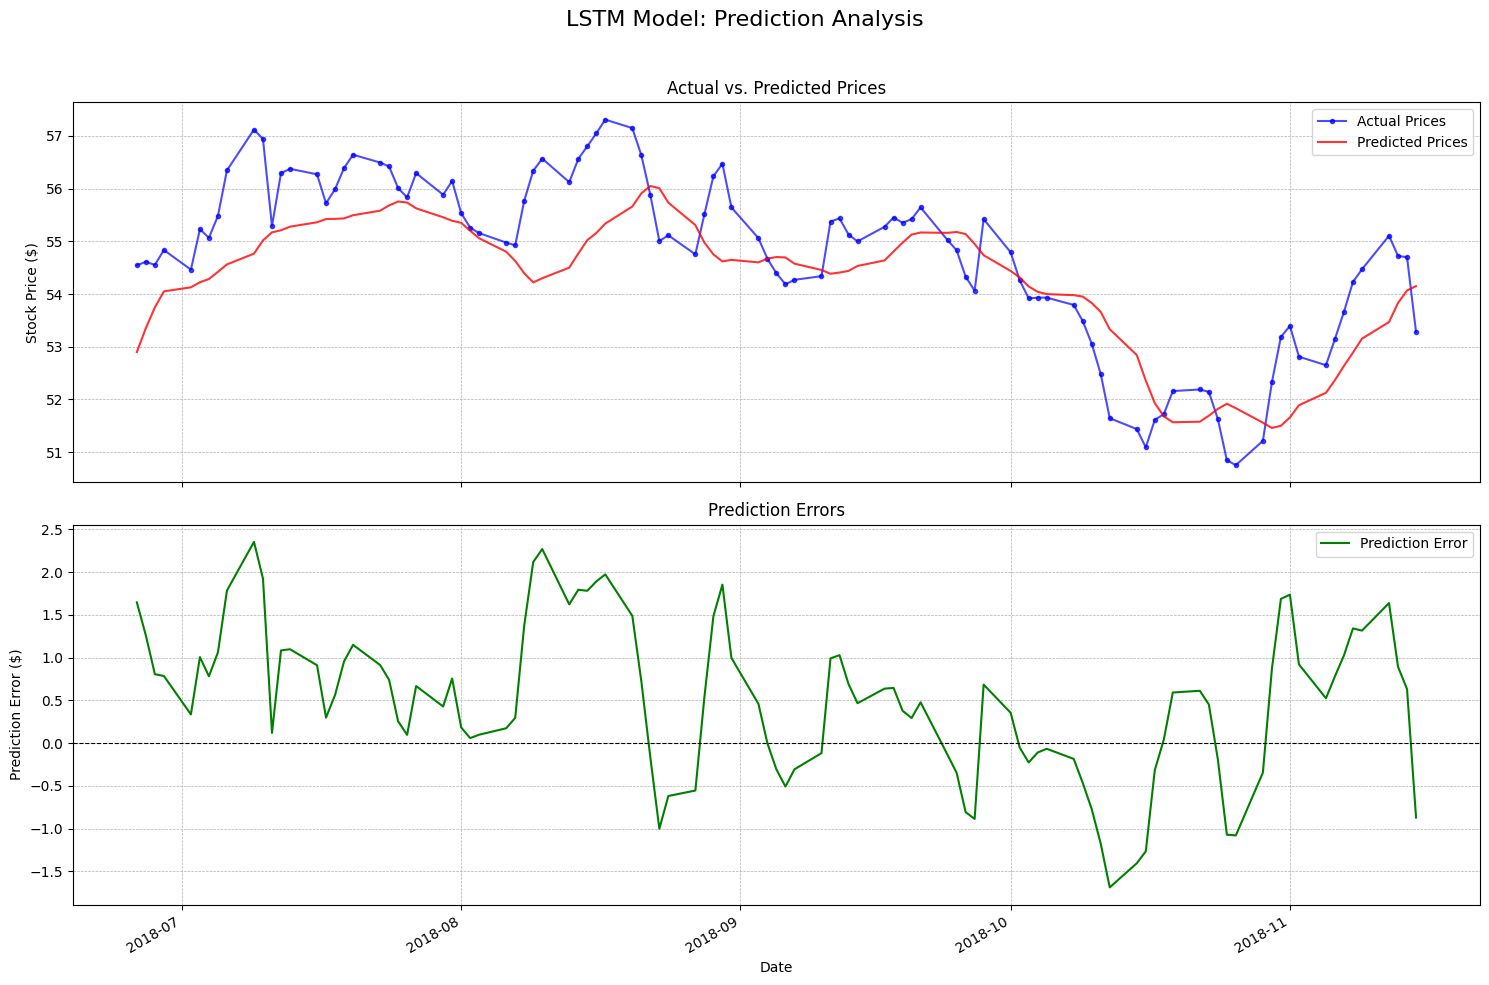


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
50 2018-09-04         54.67        54.669998  -0.00            0.00
82 2018-10-18         51.72        51.680000   0.04            0.04
70 2018-10-02         54.26        54.310001  -0.05            0.05
27 2018-08-02         55.26        55.200001   0.06            0.06
73 2018-10-05         53.93        54.000000  -0.07            0.07

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12        54.770000   2.35            2.35
33 2018-08-10         56.57        54.299999   2.27            2.27
32 2018-08-09         56.34        54.220001   2.12            2.12
38 2018-08-17         57.31        55.340000   1.97            1.97
10 2018-07-10         56.94        55.020000   1.92            1.92

--- Statistical Summary of Errors ---
count 

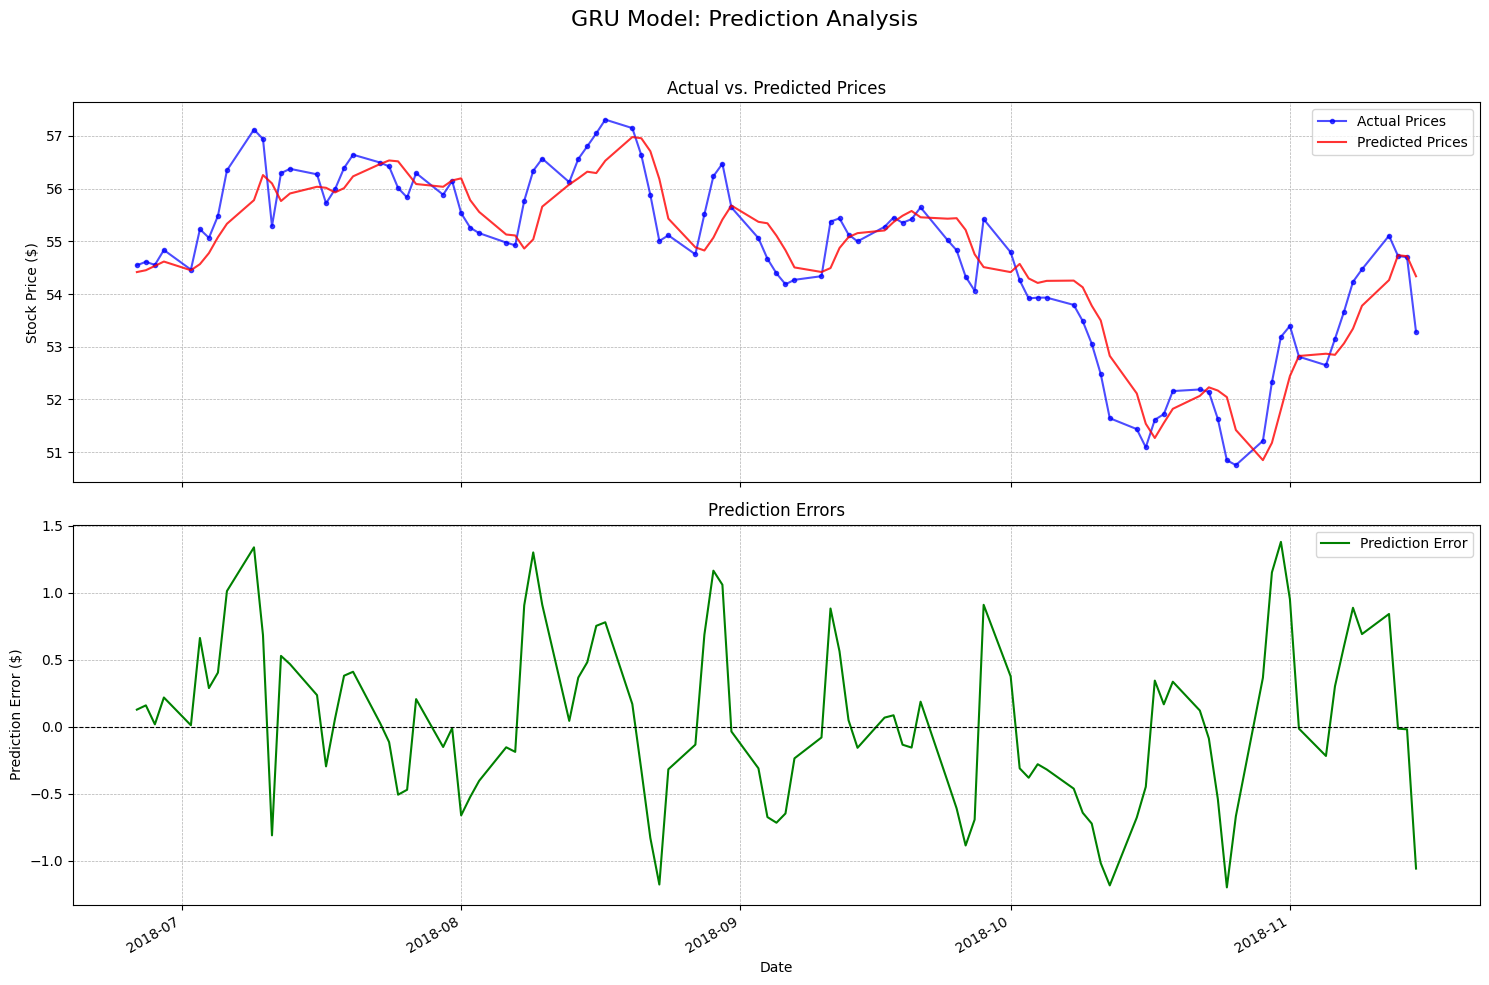


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
25  2018-07-31         56.15        56.160000  -0.01            0.01
4   2018-07-02         54.46        54.450001   0.01            0.01
93  2018-11-02         52.81        52.830002  -0.01            0.01
100 2018-11-13         54.72        54.740002  -0.01            0.01
101 2018-11-14         54.70        54.720001  -0.02            0.02

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
91 2018-10-31         53.19        51.810001   1.38            1.38
9  2018-07-09         57.12        55.779999   1.34            1.34
32 2018-08-09         56.34        55.040001   1.30            1.30
87 2018-10-25         50.85        52.040001  -1.20            1.20
78 2018-10-12         51.65        52.830002  -1.18            1.18

--- Statistical Summary of Errors ---


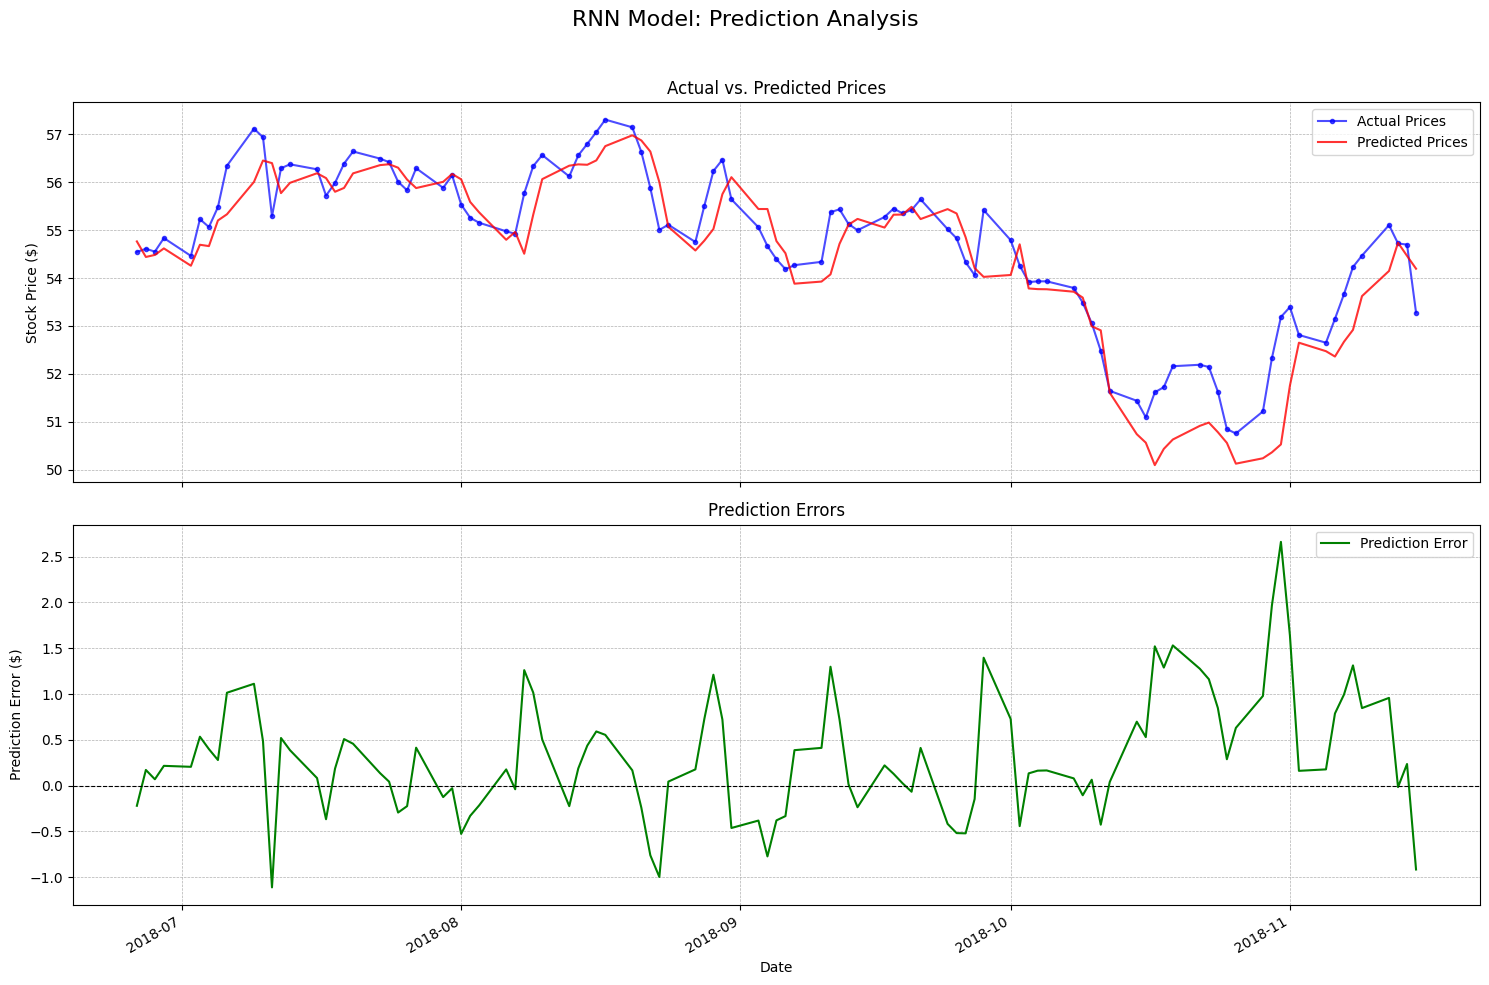


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
57  2018-09-13         55.13        55.119999   0.01            0.01
100 2018-11-13         54.72        54.740002  -0.02            0.02
61  2018-09-19         55.35        55.330002   0.03            0.03
25  2018-07-31         56.15        56.180000  -0.03            0.03
78  2018-10-12         51.65        51.610001   0.04            0.04

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
91 2018-10-31         53.19        50.529999   2.66            2.66
90 2018-10-30         52.33        50.360001   1.97            1.97
92 2018-11-01         53.40        51.759998   1.64            1.64
83 2018-10-19         52.16        50.630001   1.53            1.53
81 2018-10-17         51.61        50.090000   1.52            1.52

--- Statistical Summary of Errors ---


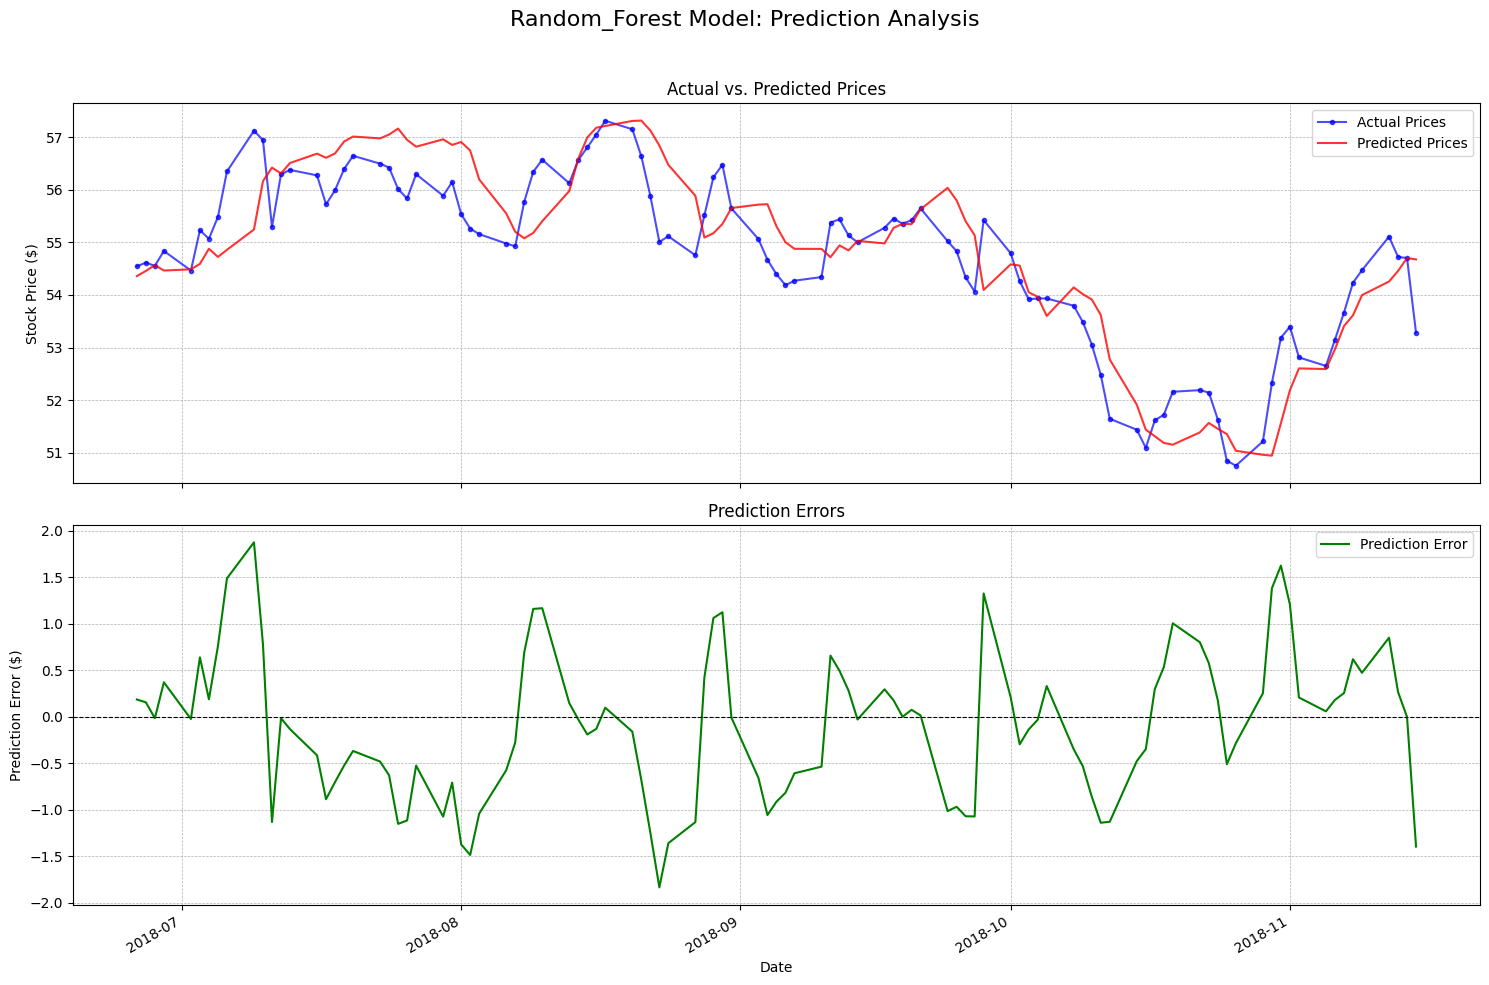


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
101 2018-11-14         54.70            54.70  -0.00            0.00
61  2018-09-19         55.35            55.35   0.00            0.00
48  2018-08-31         55.64            55.65  -0.01            0.01
12  2018-07-12         56.30            56.31  -0.01            0.01
2   2018-06-28         54.55            54.57  -0.01            0.01

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12            55.24   1.88            1.88
42 2018-08-23         55.01            56.84  -1.83            1.83
91 2018-10-31         53.19            51.56   1.63            1.63
8  2018-07-06         56.35            54.86   1.49            1.49
27 2018-08-02         55.26            56.75  -1.49            1.49

--- Statistical Summary of Errors ---


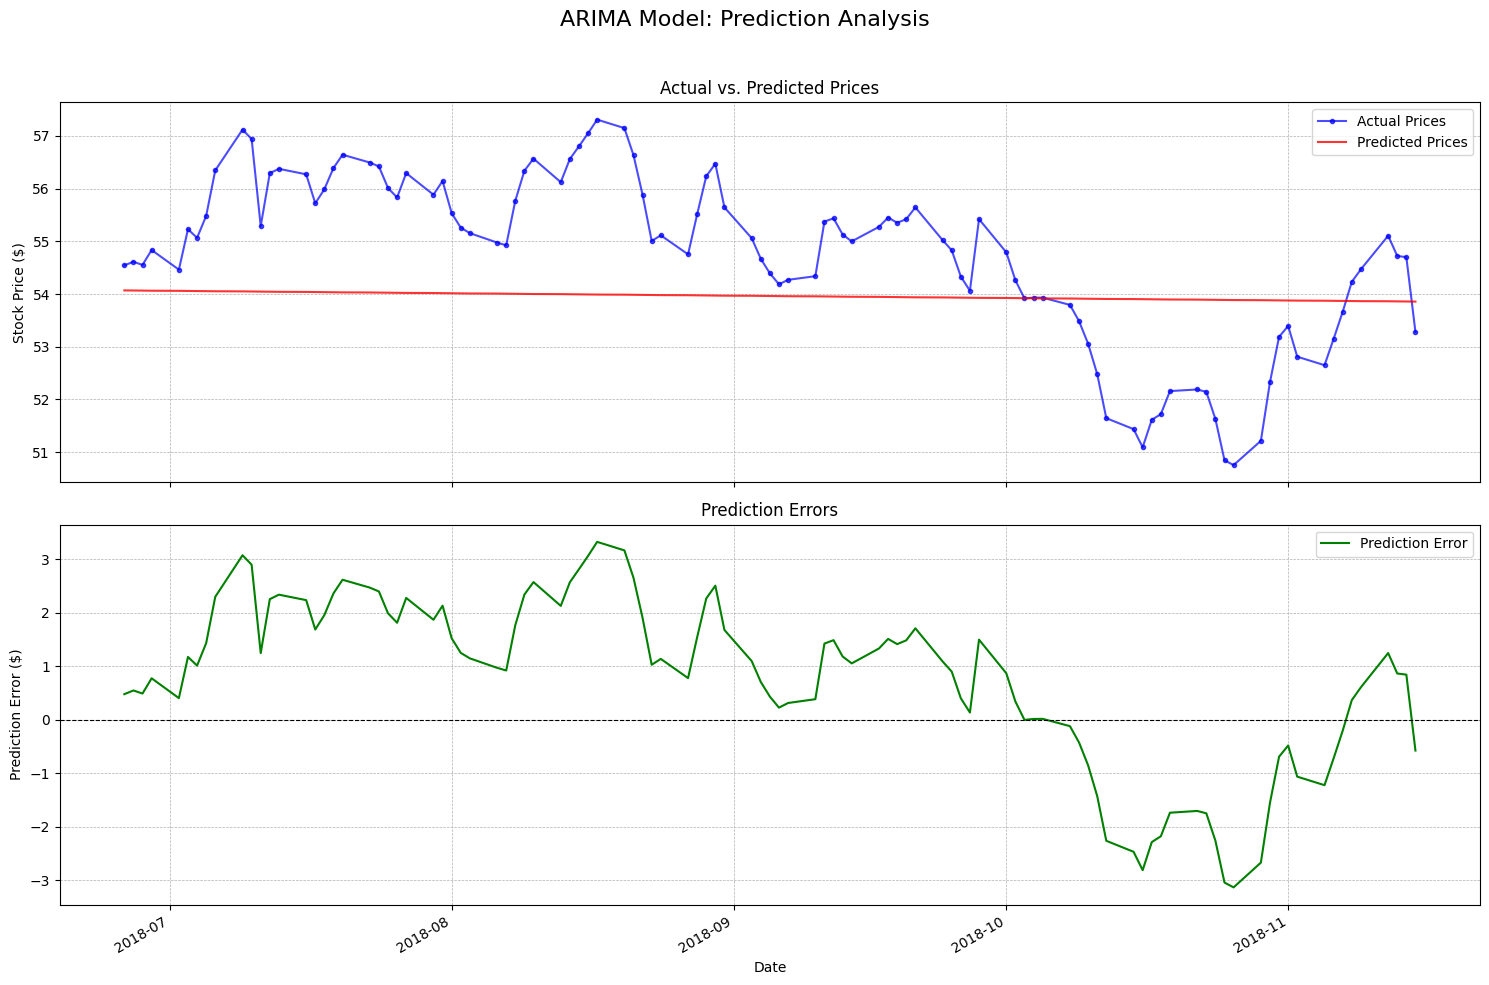


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
71 2018-10-03         53.92            53.92  -0.00            0.00
72 2018-10-04         53.93            53.92   0.01            0.01
73 2018-10-05         53.93            53.92   0.01            0.01
74 2018-10-08         53.79            53.92  -0.12            0.12
67 2018-09-27         54.06            53.93   0.13            0.13

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
38 2018-08-17         57.31            53.99   3.32            3.32
39 2018-08-20         57.15            53.99   3.16            3.16
88 2018-10-26         50.75            53.89  -3.13            3.13
9  2018-07-09         57.12            54.05   3.07            3.07
37 2018-08-16         57.05            53.99   3.06            3.06

--- Statistical Summary of Errors ---
count 

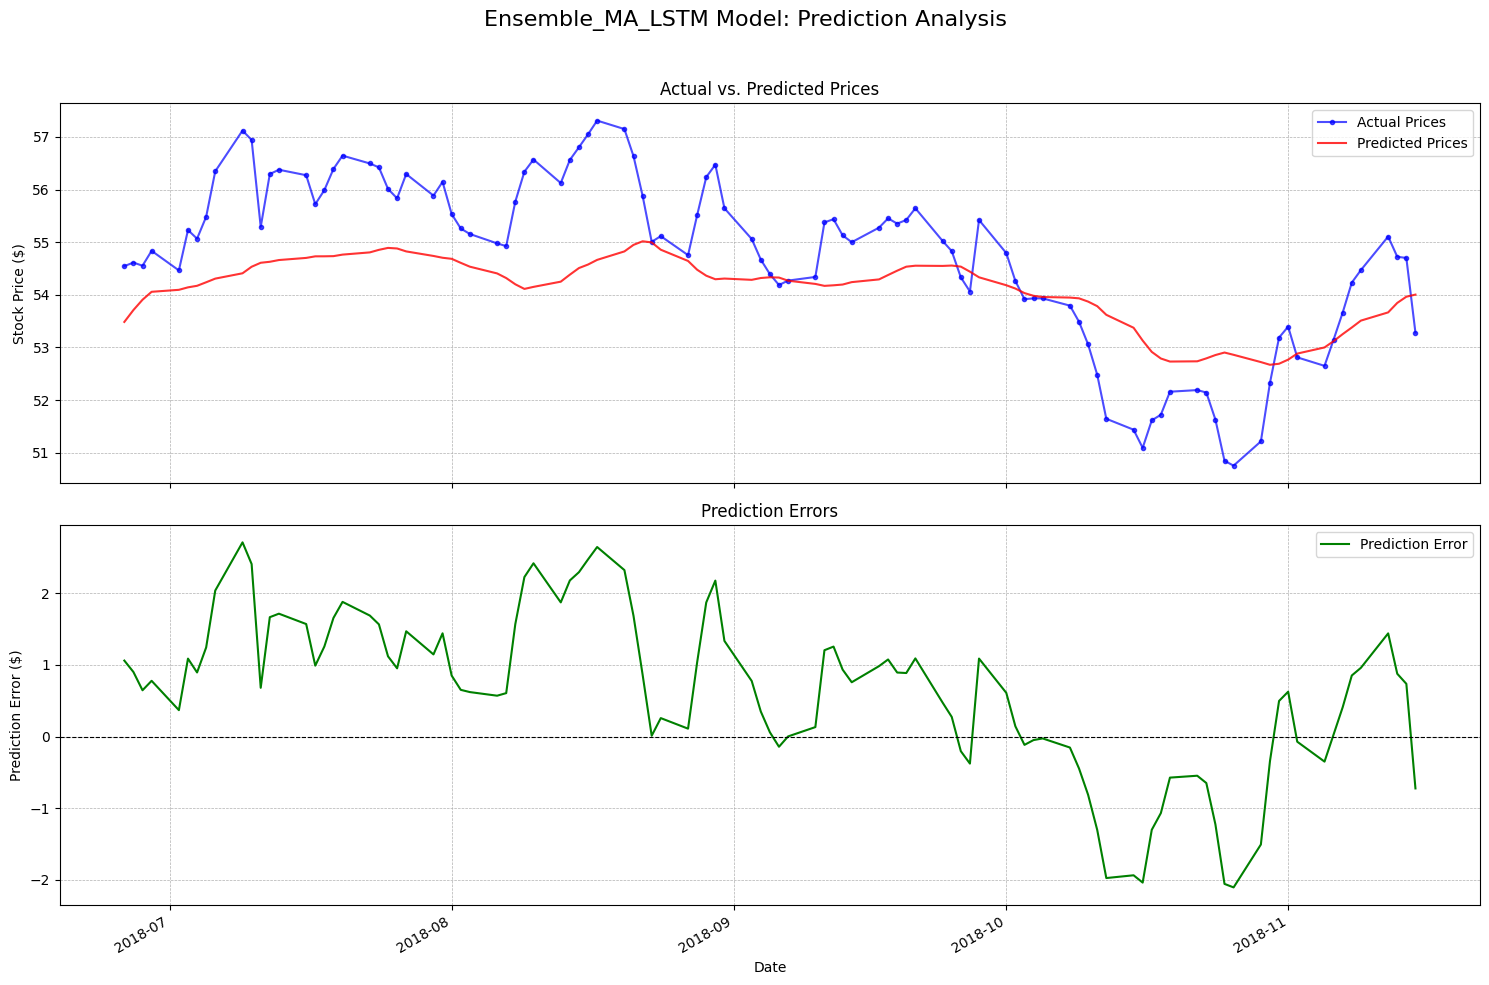


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
53 2018-09-07         54.27            54.27   0.00            0.00
42 2018-08-23         55.01            55.00   0.01            0.01
73 2018-10-05         53.93            53.96  -0.03            0.03
95 2018-11-06         53.15            53.12   0.03            0.03
72 2018-10-04         53.93            53.98  -0.05            0.05

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12            54.41   2.71            2.71
38 2018-08-17         57.31            54.66   2.65            2.65
37 2018-08-16         57.05            54.58   2.47            2.47
33 2018-08-10         56.57            54.15   2.42            2.42
10 2018-07-10         56.94            54.53   2.41            2.41

--- Statistical Summary of Errors ---
count 

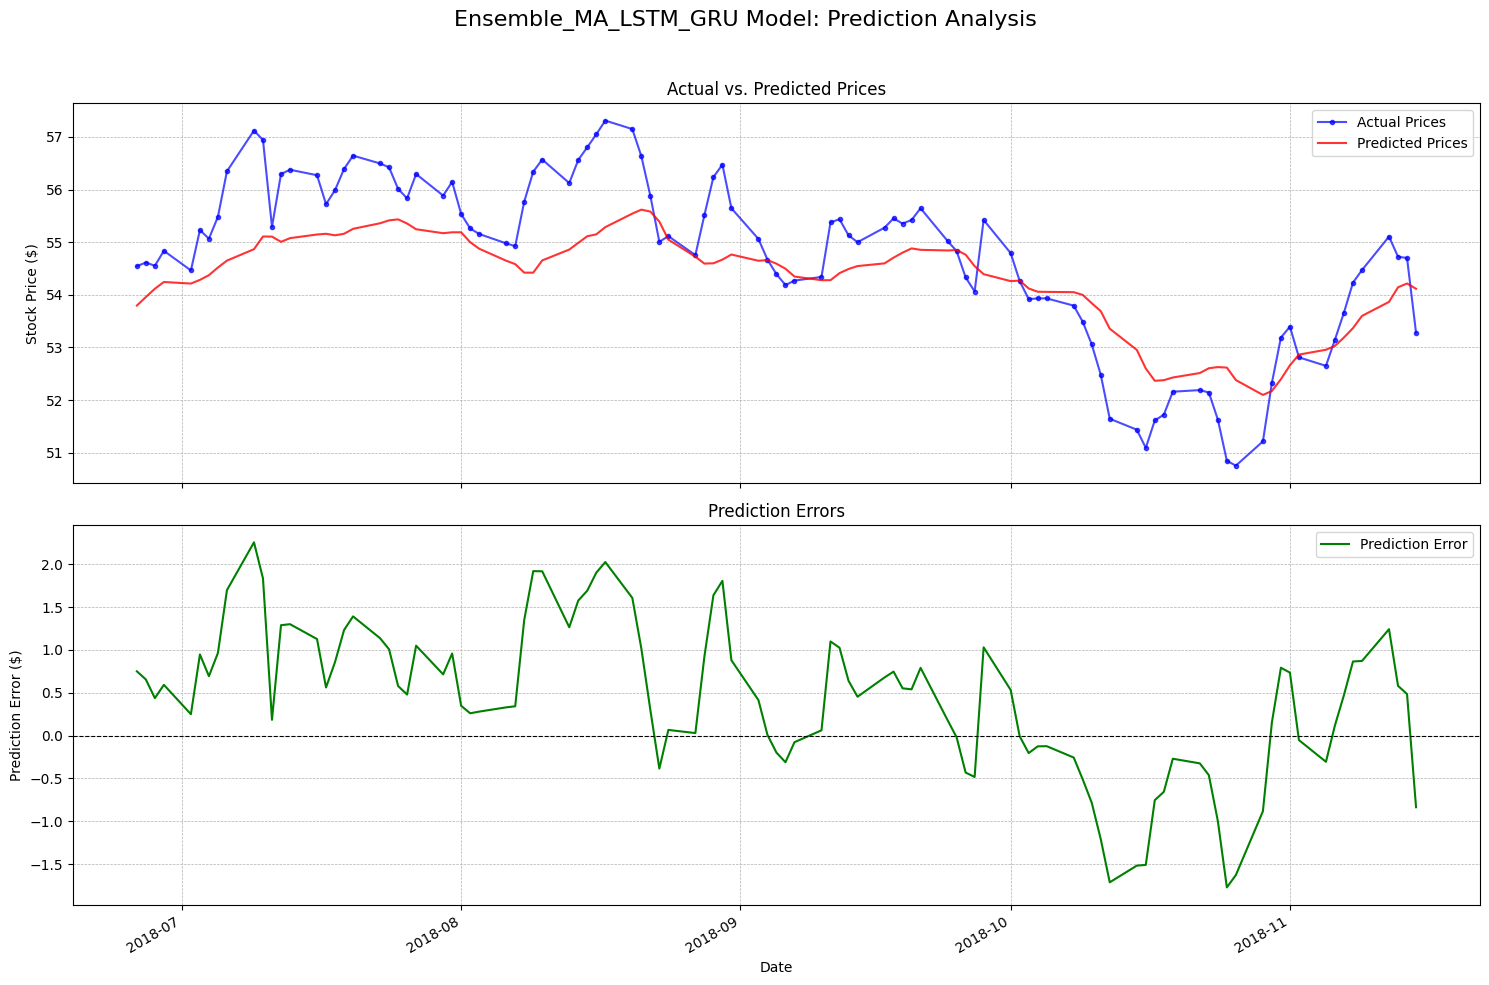


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
70 2018-10-02         54.26            54.27  -0.01            0.01
50 2018-09-04         54.67            54.66   0.01            0.01
65 2018-09-25         54.83            54.85  -0.02            0.02
44 2018-08-27         54.75            54.73   0.03            0.03
93 2018-11-02         52.81            52.86  -0.05            0.05

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12            54.87   2.25            2.25
38 2018-08-17         57.31            55.29   2.02            2.02
32 2018-08-09         56.34            54.42   1.92            1.92
33 2018-08-10         56.57            54.65   1.92            1.92
37 2018-08-16         57.05            55.15   1.90            1.90

--- Statistical Summary of Errors ---
count 

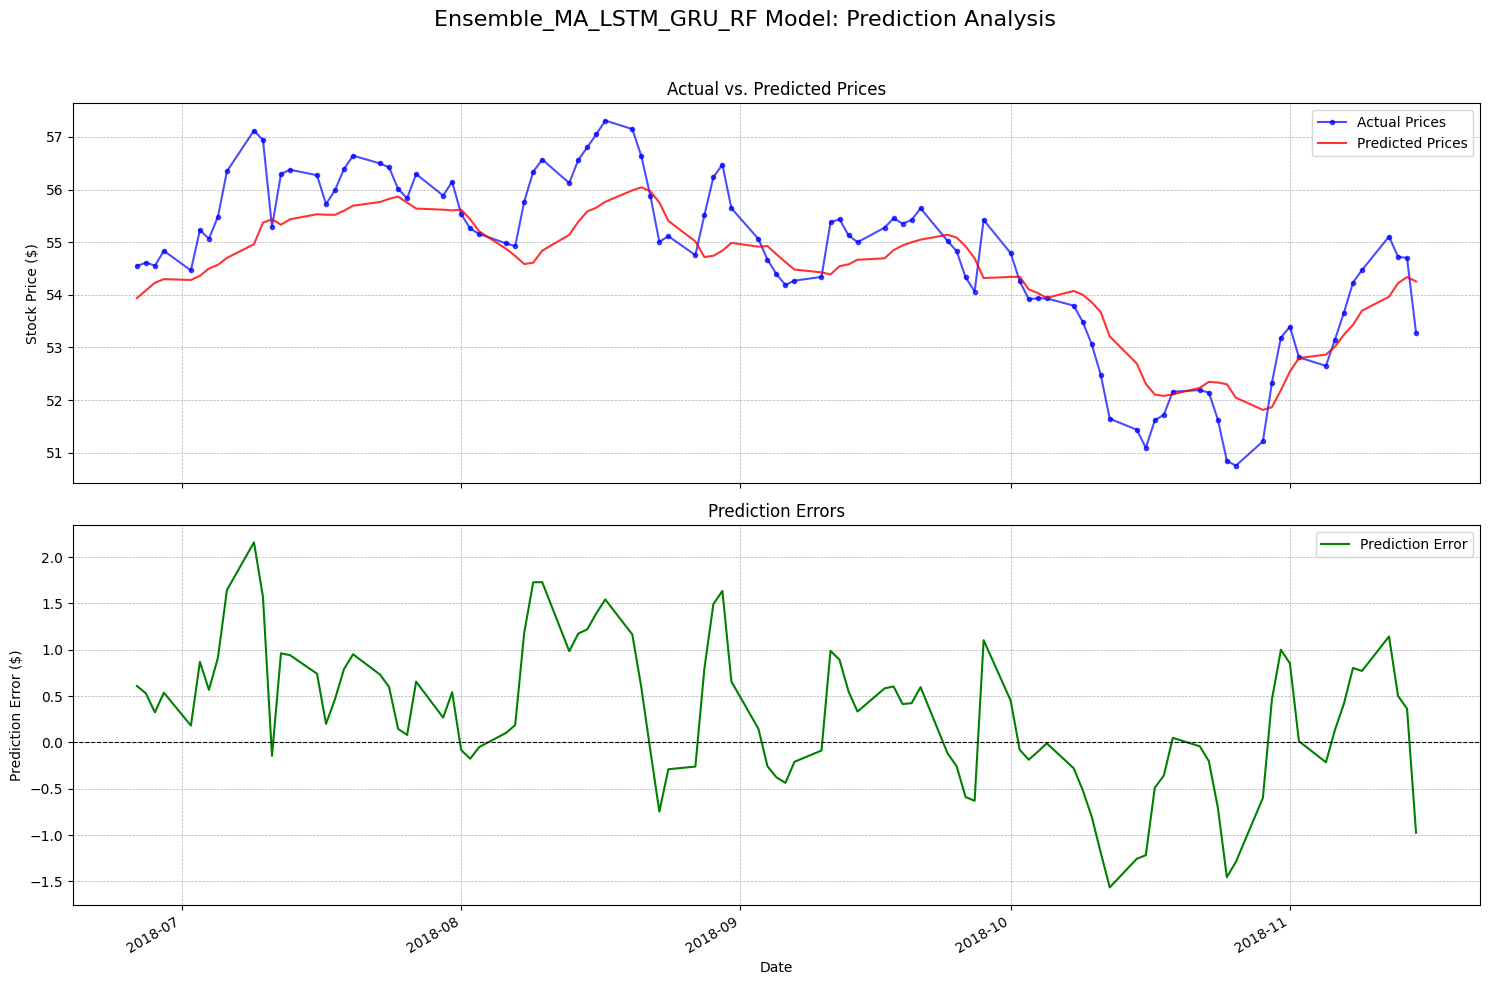


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
73 2018-10-05         53.93            53.94  -0.01            0.01
93 2018-11-02         52.81            52.80   0.01            0.01
84 2018-10-22         52.19            52.23  -0.04            0.04
83 2018-10-19         52.16            52.11   0.05            0.05
28 2018-08-03         55.16            55.21  -0.05            0.05

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12            54.96   2.16            2.16
33 2018-08-10         56.57            54.84   1.73            1.73
32 2018-08-09         56.34            54.61   1.73            1.73
8  2018-07-06         56.35            54.70   1.65            1.65
47 2018-08-30         56.47            54.84   1.64            1.64

--- Statistical Summary of Errors ---
count 

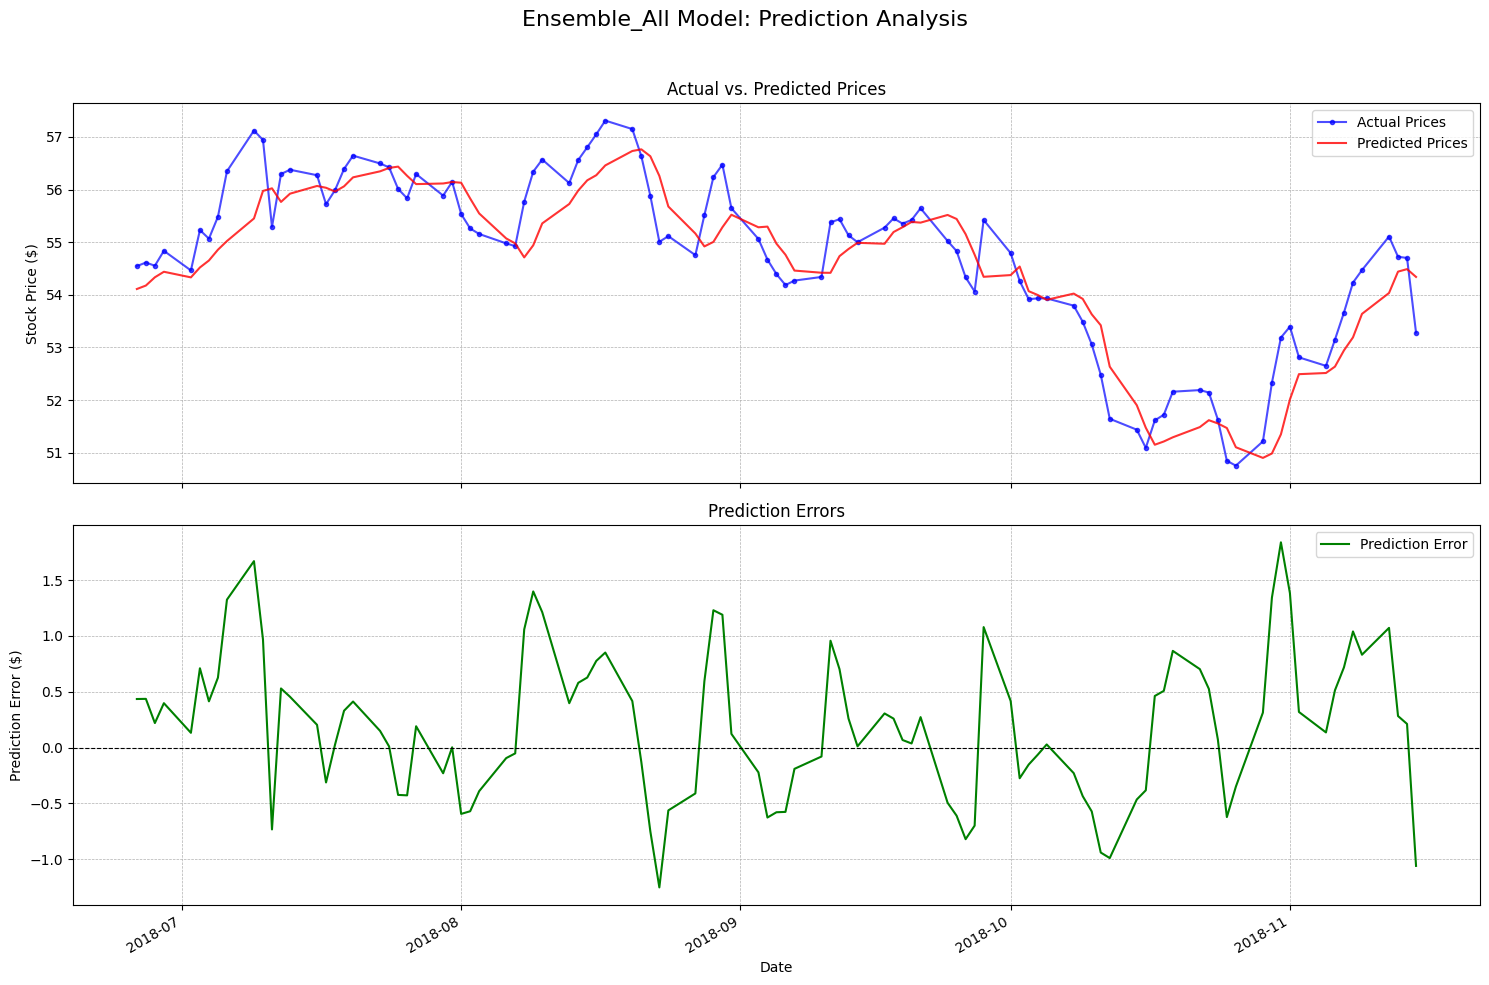


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
25 2018-07-31         56.15            56.14   0.00            0.00
20 2018-07-24         56.42            56.41   0.01            0.01
58 2018-09-14         55.00            54.99   0.01            0.01
16 2018-07-18         55.99            55.96   0.03            0.03
73 2018-10-05         53.93            53.90   0.03            0.03

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
91 2018-10-31         53.19            51.35   1.84            1.84
9  2018-07-09         57.12            55.45   1.67            1.67
32 2018-08-09         56.34            54.94   1.40            1.40
92 2018-11-01         53.40            52.01   1.38            1.38
90 2018-10-30         52.33            50.99   1.34            1.34

--- Statistical Summary of Errors ---
count 

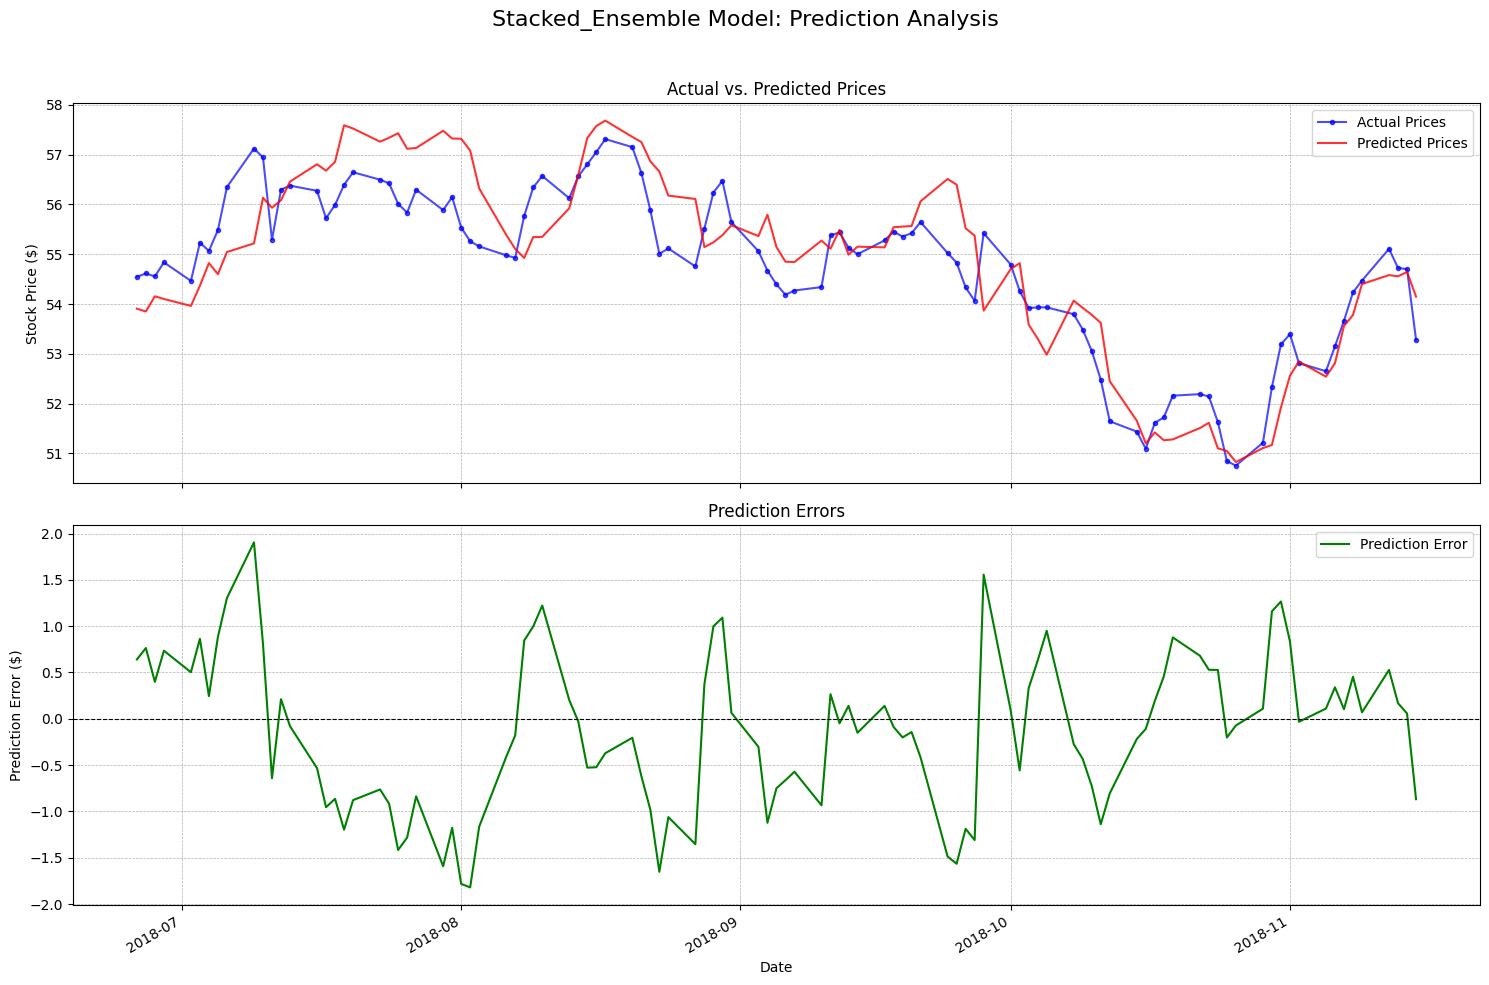


--- Prediction Highlights & Lowlights ---

✅ 5 Best Predictions (Lowest Absolute Error):
          Date  Actual_Price  Predicted_Price  Error  Absolute_Error
35  2018-08-14         56.56            56.59  -0.03            0.03
93  2018-11-02         52.81            52.84  -0.03            0.03
56  2018-09-12         55.44            55.49  -0.05            0.05
101 2018-11-14         54.70            54.64   0.06            0.06
48  2018-08-31         55.64            55.58   0.06            0.06

❌ 5 Worst Predictions (Highest Absolute Error):
         Date  Actual_Price  Predicted_Price  Error  Absolute_Error
9  2018-07-09         57.12            55.22   1.90            1.90
27 2018-08-02         55.26            57.08  -1.82            1.82
26 2018-08-01         55.54            57.32  -1.78            1.78
42 2018-08-23         55.01            56.66  -1.65            1.65
24 2018-07-30         55.89            57.48  -1.59            1.59

--- Statistical Summary of Errors ---


In [23]:
# Model Evaluation and Visualization
# --- Prepare Data for Evaluation ---
# Extract the actual prices and dates from the dataframe
actual_prices = predictions_viz_data['Actual']
prediction_dates = predictions_viz_data['Date']

# Get a list of all model prediction columns to iterate over
model_columns = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]

# --- Calculate and Display Overall Metrics ---
metrics = []
for model_name in model_columns:
    pred_prices = predictions_viz_data[model_name]
    mae = mean_absolute_error(actual_prices, pred_prices)
    mse = mean_squared_error(actual_prices, pred_prices)
    rmse = np.sqrt(mse)
    metrics.append({'Model': model_name, 'MAE ($)': mae, 'MSE': mse, 'RMSE ($)': rmse})

metrics_df = pd.DataFrame(metrics).set_index('Model')
print("\n--- Overall Prediction Performance Metrics (Sorted by MAE) ---")
print(metrics_df.sort_values('MAE ($)').round(4))
print("==============================================================")


# --- Detailed Analysis and Visualization for Each Model ---
for model_name in model_columns:
    print(f"\n--- Detailed Analysis for {model_name} Model ---")
    
    # Create a results DataFrame for the current model
    results_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual_Price': actual_prices.values,
        'Predicted_Price': predictions_viz_data[model_name].values
    })
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    # Save this model's predictions to a CSV file
    predictions_filename = os.path.join(DATA_DIR, f"{COMPANY}_predictions_{model_name}.csv")
    results_df.to_csv(predictions_filename, index=False)
    print(f"✅ Predictions for {model_name} saved to: {predictions_filename}")
    
    # Plot predictions vs. actuals and the prediction errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{model_name} Model: Prediction Analysis', fontsize=16)
    
    ax1.plot(results_df['Date'], results_df['Actual_Price'], label='Actual Prices', color='blue', linestyle='-', marker='.', alpha=0.7)
    ax1.plot(results_df['Date'], results_df['Predicted_Price'], label='Predicted Prices', color='red', linestyle='-', alpha=0.8)
    ax1.set_ylabel('Stock Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', linewidth=0.5)
    
    ax2.plot(results_df['Date'], results_df['Error'], label='Prediction Error', color='green', linestyle='-')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Prediction Error ($)')
    ax2.set_title('Prediction Errors')
    ax2.legend()
    ax2.grid(True, linestyle='--', linewidth=0.5)
    
    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Show the best and worst predictions for this model
    print("\n--- Prediction Highlights & Lowlights ---")
    print("\n✅ 5 Best Predictions (Lowest Absolute Error):")
    print(results_df.sort_values('Absolute_Error').head(5).round(2))
    print("\n❌ 5 Worst Predictions (Highest Absolute Error):")
    print(results_df.sort_values('Absolute_Error', ascending=False).head(5).round(2))
    
    print("\n--- Statistical Summary of Errors ---")
    print(results_df['Error'].describe().round(4))

In [24]:
# Interactive Candlestick Visualization

# --- Prerequisite Check ---
try:
    predictions_viz_data
    print("✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.")
except NameError:
    print("❌ CRITICAL ERROR: 'predictions_viz_data' DataFrame not found.")
    print("   Please ensure the 'Ensemble Modeling' and 'Improved Stacked Ensemble Modeling' cells have been run successfully.")
    raise

# --- Visualization Functions (no changes needed) ---
def create_candlestick_data(df, n_days=1):
    """Aggregate daily data into N-day candlesticks."""
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    if n_days == 1:
        return df
    grouped = df.groupby(np.arange(len(df)) // n_days).agg(
        Date=('Date', 'first'),
        Open=('Open', 'first'),
        High=('High', 'max'),
        Low=('Low', 'min'),
        Close=('Close', 'last'),
        Volume=('Volume', 'sum'),
        Actual_Price=('Actual_Price', 'last'),
        Predicted_Price=('Predicted_Price', 'last'),
    )
    return grouped

def plot_prediction_candlesticks(df, title, n_days, limit_days):
    """Create a candlestick chart with predictions overlay."""
    plot_data = df.copy()
    if limit_days:
        plot_data = plot_data.tail(limit_days)
    plot_data = create_candlestick_data(plot_data, n_days=n_days)
    
    if plot_data.empty:
        print("No data available to plot.")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    plot_data['Date_Num'] = mdates.date2num(pd.to_datetime(plot_data['Date']))
    width = 0.8 * n_days
    
    for index, row in plot_data.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        ax1.plot([row['Date_Num'], row['Date_Num']], [row['Low'], row['High']], color='black', linewidth=1)
        body = Rectangle((row['Date_Num'] - width/2, min(row['Open'], row['Close'])), width, abs(row['Close'] - row['Open']), facecolor=color, edgecolor='black')
        ax1.add_patch(body)
    
    ax1.plot(plot_data['Date_Num'], plot_data['Actual_Price'], label='Actual Price', color='blue', linestyle='--', alpha=0.9, linewidth=2)
    ax1.plot(plot_data['Date_Num'], plot_data['Predicted_Price'], label='Predicted Price', color='orange', linestyle='-', alpha=0.9, linewidth=2)
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Actual vs. Predicted Prices')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    volume_colors = ['green' if row['Close'] >= row['Open'] else 'red' for _, row in plot_data.iterrows()]
    ax2.bar(plot_data['Date_Num'], plot_data['Volume'], width=width, color=volume_colors, alpha=0.6)
    ax2.set_ylabel('Volume')
    ax2.set_title('Volume')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Interactive Loop ---
# Get the list of all available models for visualization
available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
model_map = {str(i + 1): model for i, model in enumerate(available_models)}

while True:
    print("\n--- Interactive Candlestick Visualization ---")
    # Dynamically create the menu of all available models
    for key, model_name in model_map.items():
        print(f"{key}: {model_name}")
    print("q: Quit")
    
    choice = input(f"Enter your choice (1-{len(model_map)}/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting visualization.")
        break
    
    if choice not in model_map:
        print("❌ Invalid choice. Please select a number from the list.")
        continue
    
    model_name = model_map[choice]
    
    try:
        n_days_input = input("Enter number of days per candlestick (default: 1): ").strip()
        n_days = int(n_days_input) if n_days_input else 1
        
        limit_days_input = input("Enter number of recent days to display (default: 90): ").strip()
        limit_days = int(limit_days_input) if limit_days_input else 90
    except ValueError:
        print("❌ Invalid number. Using defaults.")
        n_days, limit_days = 1, 90
    
    try:
        # --- Prepare DataFrame for Plotting ---
        # Merge OHLCV data from `test_data` with predictions from `predictions_viz_data`.
        
        pred_subset = predictions_viz_data[['Date', 'Actual', model_name]].copy()
        
        # The original data uses 'Price' for the open price. Rename it to 'Open' for the plot.
        if 'Open' not in test_data.columns and 'Price' in test_data.columns:
             test_data_plot = test_data.rename(columns={'Price': 'Open'})
        else:
             test_data_plot = test_data.copy()

        # Merge on 'Date' to ensure data is perfectly aligned
        plot_df = pd.merge(test_data_plot, pred_subset, on='Date', how='inner')
        
        # Rename columns to what the plotting function expects
        plot_df = plot_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'})
        
        # Call the plotting function
        plot_prediction_candlesticks(
            plot_df, 
            f"{COMPANY} - {model_name} Model Predictions", 
            n_days, 
            limit_days
        )
    except Exception as e:
        print(f"❌ An unexpected error occurred while preparing the plot:")

✅ Found 'predictions_viz_data' DataFrame. Ready for visualization.

--- Interactive Candlestick Visualization ---
1: LSTM
2: GRU
3: RNN
4: Random_Forest
5: ARIMA
6: Ensemble_MA_LSTM
7: Ensemble_MA_LSTM_GRU
8: Ensemble_MA_LSTM_GRU_RF
9: Ensemble_All
10: Stacked_Ensemble
q: Quit
Exiting visualization.


In [25]:
# Boxplot Analysis
# --- Visualization Functions (no changes needed) ---
def create_boxplot_data(df, period='monthly'):
    """Prepare data for boxplot visualization."""
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    if period == 'monthly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-%m')
    elif period == 'quarterly':
        df_copy['Period'] = df_copy['Date'].dt.to_period('Q').astype(str)
    elif period == 'yearly':
        df_copy['Period'] = df_copy['Date'].dt.year.astype(str)
    elif period == 'weekly':
        df_copy['Period'] = df_copy['Date'].dt.strftime('%Y-W%U')
    else:
        raise ValueError("Period must be one of 'monthly', 'quarterly', 'yearly', or 'weekly'")
    
    df_copy['Price_Range'] = df_copy['High'] - df_copy['Low']
    df_copy['Daily_Return'] = df_copy['Close'].pct_change() * 100
    return df_copy

def plot_price_boxplots(df, period='monthly'):
    """Create boxplots for historical stock data."""
    boxplot_data = create_boxplot_data(df, period)
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'Historical Stock Analysis by {period.title()}', fontsize=16)
    
    sns.boxplot(ax=axes[0, 0], data=boxplot_data, x='Period', y='Close', palette='viridis')
    axes[0, 0].set_title('Close Price Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[0, 1], data=boxplot_data, x='Period', y='Price_Range', palette='plasma')
    axes[0, 1].set_title('Daily Price Range (Volatility)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 0], data=boxplot_data, x='Period', y='Volume', palette='magma')
    axes[1, 0].set_title('Trading Volume Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(ax=axes[1, 1], data=boxplot_data, x='Period', y='Daily_Return', palette='cividis')
    axes[1, 1].set_title('Daily Returns Distribution (%)')
    axes[1, 1].axhline(0, color='black', linestyle='--')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_prediction_error_boxplots(results_df, model_name):
    """Create boxplots for prediction errors."""
    results_df['Error'] = results_df['Actual_Price'] - results_df['Predicted_Price']
    results_df['Absolute_Error'] = np.abs(results_df['Error'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle(f'{model_name} Model: Prediction Error Analysis', fontsize=16)
    
    sns.boxplot(ax=ax1, y=results_df['Error'], palette='coolwarm')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_title('Prediction Error')
    ax1.set_ylabel('Error ($)')
    
    sns.boxplot(ax=ax2, y=results_df['Absolute_Error'], palette='spring')
    ax2.set_title('Absolute Prediction Error')
    ax2.set_ylabel('Absolute Error ($)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Interactive Loop ---
while True:
    print("\n--- Boxplot Analysis Menu ---")
    print("1: Historical Data Analysis")
    print("2: Prediction Error Analysis")
    print("q: Quit")
    choice = input("Enter your choice (1/2/q): ").strip().lower()
    
    if choice == 'q':
        print("Exiting boxplot analysis.")
        break
    
    try:
        if choice == '1':
            print("\nSelect period for historical analysis:")
            print("1: Monthly\n2: Quarterly\n3: Yearly\n4: Weekly")
            period_choice = input("Enter choice [default: 1]: ").strip()
            period_map = {'1': 'monthly', '2': 'quarterly', '3': 'yearly', '4': 'weekly'}
            period = period_map.get(period_choice, 'monthly')
            
            # Concatenate train and test data to get the full historical range
            full_historical_df = pd.concat([train_data, test_data], ignore_index=True)
            plot_price_boxplots(full_historical_df, period=period)
        
        elif choice == '2':
            # Dynamically get all available models for error analysis
            available_models = [col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]
            model_map = {str(i + 1): model for i, model in enumerate(available_models)}
            
            print("\nSelect a model for prediction error analysis:")
            for key, model_name in model_map.items():
                print(f"{key}: {model_name}")
            
            model_choice = input(f"Enter choice (1-{len(model_map)}): ").strip()
            
            if model_choice not in model_map:
                print("❌ Invalid model choice.")
                continue
                
            model_name = model_map[model_choice]
            
            # Create the dataframe for the selected model from the master visualization data
            prediction_df = predictions_viz_data[['Actual', model_name]].copy()
            prediction_df.rename(columns={'Actual': 'Actual_Price', model_name: 'Predicted_Price'}, inplace=True)
            
            plot_prediction_error_boxplots(prediction_df, model_name)
        
        else:
            print("❌ Invalid choice. Please enter 1, 2, or q.")
            
    except Exception as e:
        print(f"❌ An error occurred: {e}")


--- Boxplot Analysis Menu ---
1: Historical Data Analysis
2: Prediction Error Analysis
q: Quit
Exiting boxplot analysis.


In [26]:
# Multistep Prediction Functions
def solve_multivariate_multistep_prediction(model, last_sequence, k, scalers, feature_order):
    """Predict k days into the future using multivariate input."""
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(k):
        next_close_scaled = model.predict(current_sequence.reshape(1, PREDICTION_DAYS, -1), verbose=0)[0, 0]
        predictions.append(scalers['Close'].inverse_transform([[next_close_scaled]])[0, 0])
        
        new_step = current_sequence[0, -1, :].copy()
        close_feature_index = feature_order.index('Close')
        new_step[close_feature_index] = next_close_scaled
        new_step = new_step.reshape(1, 1, current_sequence.shape[2])
        current_sequence = np.append(current_sequence[:, 1:, :], new_step, axis=1)
    
    return predictions

In [27]:
# Advanced Future Predictions
# --- Prerequisite Checks ---
try:
    # Check for all necessary models and variables
    all_models_performance
    lstm_model
    gru_model
    rnn_model
    rf_model
    fitted_arima
    meta_learner
    weights
    scalers
    test_values
    feature_columns
    PREDICTION_DAYS
    create_rf_features
    print("✅ All prerequisite models and variables found. Ready for future prediction.")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable or model is missing: {e}")
    print("   Please ensure all preceding cells, especially model training and ensemble creation, have been run successfully.")
    raise

def generate_future_predictions(model_name, future_days, last_sequence, all_models, scalers, feature_columns):
    """
    Generates future predictions using a direct forecasting strategy.
    This is much simpler as it does not require a recursive loop.
    """
    # Unpack all models from the dictionary
    lstm_m = all_models.get('LSTM')
    gru_m = all_models.get('GRU')
    rnn_m = all_models.get('RNN')
    rf_m = all_models.get('Random_Forest')
    arima_m = all_models.get('ARIMA')
    meta_learner_m = all_models.get('Stacked_Ensemble_Meta')
    weights_m = all_models.get('Weighted_Ensemble_Weights')

    print(f"Generating a direct {future_days}-day forecast for '{model_name}'...")

    # --- Step 1: Get the full forecast from the required base models ---
    # The input sequence is the same for all NN and RF models
    nn_input_seq = last_sequence.reshape(1, PREDICTION_DAYS, len(feature_columns))

    # Predict ONCE to get all future days for each model.
    # The NN/RF models will predict 30 days, so we slice the result.
    base_preds_scaled = {
        'LSTM': lstm_m.predict(nn_input_seq, verbose=0)[0][:future_days],
        'GRU': gru_m.predict(nn_input_seq, verbose=0)[0][:future_days],
        'RNN': rnn_m.predict(nn_input_seq, verbose=0)[0][:future_days]
    }
    
    # For RF, we must re-create the features from the sequence
    rf_features, _ = create_rf_features(nn_input_seq, np.zeros(nn_input_seq.shape[0]))
    base_preds_scaled['Random_Forest'] = rf_m.predict(rf_features).flatten()[:future_days]
    
    # ARIMA forecasts the correct number of steps natively
    arima_preds_unscaled = arima_m.forecast(steps=future_days)
    base_preds_scaled['ARIMA'] = scalers['Close'].transform(arima_preds_unscaled.values.reshape(-1, 1)).flatten()

    # --- Step 2: Select or Ensemble the forecasts ---
    final_pred_scaled = None
    if model_name in base_preds_scaled:
        final_pred_scaled = base_preds_scaled[model_name]
    
    elif model_name == 'Ensemble_All':
        # Average the predictions from all base models
        final_pred_scaled = np.mean([preds for preds in base_preds_scaled.values()], axis=0)
        
    elif model_name == 'Stacked_Ensemble':
        print("  - Using Stacked Ensemble...")
        # FIX: Use only the models the meta-learner was trained on (LSTM, GRU, RNN, RF).
        # This ensures the input has the correct number of features (4 models * 30 days = 120).
        stacking_preds = [
            base_preds_scaled['LSTM'],
            base_preds_scaled['GRU'],
            base_preds_scaled['RNN'],
            base_preds_scaled['Random_Forest']
        ]
        stacked_features = np.hstack(stacking_preds).reshape(1, -1)
        
        # The meta-learner was trained to predict 30 days, so we slice its output
        final_pred_scaled = meta_learner_m.predict(stacked_features)[0][:future_days]
        
    elif model_name == 'Weighted_Ensemble':
        print("  - Using Weighted Ensemble...")
        # Tile ARIMA to match the multi-step models for weighting
        arima_30day = np.full((future_days,), base_preds_scaled['ARIMA'][0])
        # Apply weights
        weighted_sum = (
            weights_m['LSTM'] * base_preds_scaled['LSTM'] +
            weights_m['GRU'] * base_preds_scaled['GRU'] +
            weights_m['RNN'] * base_preds_scaled['RNN'] +
            weights_m['Moving Average'] * arima_30day
        )
        final_pred_scaled = weighted_sum

    else:
        # Default to the best model if the name is not recognized
        print(f"Warning: Model '{model_name}' not found for direct prediction. Defaulting to LSTM.")
        final_pred_scaled = base_preds_scaled['LSTM']

    # --- Step 3: Descale the final prediction ---
    final_pred_unscaled = scalers['Close'].inverse_transform(final_pred_scaled.reshape(-1, 1)).flatten()
    
    print("✅ Forecast generated successfully.")
    return final_pred_unscaled

# --- Main Execution ---
# 1. Consolidate all models into a single dictionary for easy access
all_models = {
    'LSTM': lstm_model, 'GRU': gru_model, 'RNN': rnn_model,
    'Random_Forest': rf_model, 'ARIMA': fitted_arima,
    'Stacked_Ensemble_Meta': meta_learner, 'Weighted_Ensemble_Weights': weights
}

# 2. Determine the best overall model from the final ranking
best_model_name = min(all_models_performance, key=all_models_performance.get)
best_model_mae = all_models_performance[best_model_name]
print(f"🏆 Best overall model identified: '{best_model_name}' (MAE: {best_model_mae:.6f})")

# 3. Interactive loop for future prediction
while True:
    print("\n--- Future Prediction Menu ---")
    # Create a map of all available models for prediction
    available_models_list = sorted(all_models_performance.keys())
    model_map = {str(i + 1): name for i, name in enumerate(available_models_list)}
    
    print(f"d: Use default best model ({best_model_name})")
    for key, name in model_map.items():
        print(f"{key}: {name} (MAE: {all_models_performance[name]:.4f})")
    print("q: Quit")
    
    choice = input("Select a model for future prediction [d]: ").strip().lower()
    
    if choice == 'q':
        print("Exiting future prediction.")
        break
    
    chosen_model_name = best_model_name
    if choice == 'd' or choice == '':
        pass # Use default
    elif choice in model_map:
        chosen_model_name = model_map[choice]
    else:
        print("❌ Invalid choice. Please select from the list.")
        continue

    try:
        days_input = input("Enter number of future days to predict [default: 30]: ").strip()
        FUTURE_DAYS = int(days_input) if days_input else 30
        
        # Prepare the last known sequence from the test data
        last_sequence = test_values[-PREDICTION_DAYS:]
        
        # Generate the predictions
        future_predictions = generate_future_predictions(
            chosen_model_name, FUTURE_DAYS, last_sequence, all_models, scalers, feature_columns
        )
        
        # Create future dates and DataFrame
        last_date = pd.to_datetime(df['Date'].iloc[-1])
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS)
        
        future_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Close': future_predictions,
            'Model': chosen_model_name
        })
        
        print(f"\n✅ Generated {FUTURE_DAYS} future predictions using '{chosen_model_name}'")
        print(f"   Future prediction range: ${future_predictions.min():.2f} to ${future_predictions.max():.2f}")
        print("\n--- First 10 Future Predictions ---")
        print(future_df.head(10).round(2))
        
        # Ask to run again or exit
        rerun = input("\nRun again with a different model? (y/n) [n]: ").strip().lower()
        if rerun != 'y':
            break
            
    except Exception as e:
        print(f"❌ An error occurred during prediction: {e}")
        import traceback
        traceback.print_exc()
        break

✅ All prerequisite models and variables found. Ready for future prediction.
🏆 Best overall model identified: 'Ensemble_MA_LSTM_GRU_RF' (MAE: 0.655568)

--- Future Prediction Menu ---
d: Use default best model (Ensemble_MA_LSTM_GRU_RF)
1: ARIMA (MAE: 1.4916)
2: Ensemble_All (MAE: 1.3431)
3: Ensemble_MA_LSTM (MAE: 1.0598)
4: Ensemble_MA_LSTM_GRU (MAE: 0.7986)
5: Ensemble_MA_LSTM_GRU_RF (MAE: 0.6556)
6: GRU (MAE: 1.2302)
7: LSTM (MAE: 1.3196)
8: RNN (MAE: 1.4215)
9: Random Forest (MAE: 1.9495)
10: Stacked_Ensemble (MAE: 2.1203)
q: Quit
Generating a direct 30-day forecast for 'Ensemble_MA_LSTM_GRU_RF'...
✅ Forecast generated successfully.

✅ Generated 30 future predictions using 'Ensemble_MA_LSTM_GRU_RF'
   Future prediction range: $53.27 to $53.78

--- First 10 Future Predictions ---
        Date  Predicted_Close                    Model
0 2019-01-01        53.270000  Ensemble_MA_LSTM_GRU_RF
1 2019-01-02        53.290001  Ensemble_MA_LSTM_GRU_RF
2 2019-01-03        53.459999  Ensemble_MA_

In [28]:
# --- Prerequisite Checks ---
try:
    predictions_viz_data, all_models_performance, future_df, complete_data
    chosen_model_name, best_model_name, best_mae, COMPANY, FUTURE_DAYS
    print("✅ All prerequisite data found. Generating the final dashboard...")
except NameError as e:
    print(f"❌ CRITICAL ERROR: A required variable is missing: {e}")
    print("   Please ensure all preceding cells were run successfully before creating this visualization.")
    raise

✅ All prerequisite data found. Generating the final dashboard...


In [29]:
# --- Data & Color Preparation ---
# Ensure 'Open' column exists for candlestick chart
if 'Open' not in complete_data.columns:
    complete_data['Open'] = complete_data['Close'].shift(1).fillna(complete_data['Close'])

# Define a professional and consistent color palette for the dashboard
colors = {
    'primary': '#005ea6',      # Strong Blue
    'secondary': '#e87722',    # Bright Orange
    'accent': '#d62728',       # Strong Red
    'neutral': '#5a5a5a',      # Dark Gray
    'up': '#008450',           # Green
    'down': '#d62728',         # Red
    'band': 'rgba(232, 119, 34, 0.2)' # Light Orange for confidence band
}


# --- Create Visualization Dashboard ---
# The layout is strategically rearranged for a more logical narrative flow.
# Row 2 now pairs the forecast detail with historical volume for contextual analysis.
# Row 3 groups the two model performance metrics together.
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        # Row 1: The main, overarching chart remains at the top.
        '<b>Historical Price, Test Predictions & Future Forecast</b>', None,
        # Row 2: Contextual charts - detailed price action and volume.
        '<b>Forecast Detail vs. Recent History</b>', '<b>Daily Trading Volume</b>',
        # Row 3: Model evaluation charts.
        '<b>Model Performance (MAE)</b>', '<b>Prediction Error Distribution</b>'
    ),
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {}]
    ],
    vertical_spacing=0.15,
    horizontal_spacing=0.08,
    row_heights=[0.5, 0.25, 0.25] # Allocate more space to the main chart
)


# --- Plot 1: Main Chart (Row 1, Col 1) ---
# This plot combines historical data, model predictions, and the future forecast.
# It provides the primary overview of the stock's performance and outlook.

# Calculate the confidence band based on the standard deviation of all model predictions
model_preds_for_std = predictions_viz_data[[col for col in predictions_viz_data.columns if col not in ['Date', 'Actual']]]
ensemble_std = model_preds_for_std.std(axis=1)
best_preds = predictions_viz_data.get(best_model_name)
if best_preds is None:
    best_preds = pd.Series([0] * len(predictions_viz_data)) # Placeholder if best model preds are missing

# Add confidence band traces first so they render in the background
fig.add_trace(go.Scatter(
    x=predictions_viz_data['Date'], y=best_preds + (2 * ensemble_std),
    mode='lines', line=dict(width=0), showlegend=False, hoverinfo='none'
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=predictions_viz_data['Date'], y=best_preds - (2 * ensemble_std),
    mode='lines', line=dict(width=0), fill='tonexty',
    name='Confidence Band (±2σ)', fillcolor=colors['band'], hoverinfo='none'
), row=1, col=1)

# Add primary data traces
fig.add_trace(go.Candlestick(x=complete_data['Date'], open=complete_data['Open'], high=complete_data['High'], low=complete_data['Low'], close=complete_data['Close'], name='Historical Price', increasing_line_color=colors['up'], decreasing_line_color=colors['down']), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=predictions_viz_data['Actual'], mode='lines', name='Actual (Test Set)', line=dict(color='black', width=2.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=predictions_viz_data['Date'], y=best_preds, mode='lines', name=f'Best Model: {best_model_name.replace("_", " ")}', line=dict(color=colors['secondary'], width=2, dash='dot')), row=1, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines', name=f'Future Forecast ({chosen_model_name.replace("_", " ")})', line=dict(color=colors['accent'], width=3, dash='dash')), row=1, col=1)


# --- Plot 2: Forecast Detail (Row 2, Col 1) ---
# A zoomed-in view of the most recent history and the forecast period.
recent_data = complete_data.tail(90)
fig.add_trace(go.Scatter(x=recent_data['Date'], y=recent_data['Close'], mode='lines', name='Recent History', line=dict(color=colors['neutral'], width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Predicted_Close'], mode='lines+markers', name='Forecast Detail', line=dict(color=colors['accent'], width=2), marker=dict(size=5)), row=2, col=1)


# --- Plot 3: Volume Analysis (Row 2, Col 2) ---
# Shows trading volume, colored by whether the day's price went up or down.
volume_colors = [colors['up'] if c >= o else colors['down'] for o, c in zip(complete_data['Open'], complete_data['Close'])]
fig.add_trace(go.Bar(
    x=complete_data['Date'], y=complete_data['Volume'],
    name='Volume', marker_color=volume_colors, opacity=0.8
), row=2, col=2)


# --- Plot 4: Model Performance (Row 3, Col 1) ---
# A horizontal bar chart for better readability of model names, ranked by MAE.
sorted_perf = sorted(all_models_performance.items(), key=lambda item: item [1], reverse=True)
model_names_sorted = [item [0].replace('_', ' ') for item in sorted_perf]
model_maes_sorted = [item [1] for item in sorted_perf]
fig.add_trace(go.Bar(
    y=model_names_sorted, x=model_maes_sorted,
    orientation='h', name='Model MAE',
    marker_color=colors['primary'],
    text=[f'{mae:.3f}' for mae in model_maes_sorted],
    textposition='auto'
), row=3, col=1)


# --- Plot 5: Error Distribution (Row 3, Col 2) ---
# A histogram showing the distribution of the best model's prediction errors.
errors = predictions_viz_data['Actual'] - predictions_viz_data.get(best_model_name, pd.Series([0] * len(predictions_viz_data)))
fig.add_trace(go.Histogram(
    x=errors, name='Error Frequency',
    marker_color=colors['primary'], nbinsx=30
), row=3, col=2)
# Add a vertical line to indicate the mean error
fig.add_vline(x=errors.mean(), line_width=2, line_dash="dash", line_color=colors['accent'],
              annotation_text=f"Mean Error: {errors.mean():.3f}",
              annotation_position="top right", row=3, col=2)


# --- Final Layout Updates ---
# This section sets the overall theme, title, legend, and axis properties for the entire figure.
fig.update_layout(
    title_text=f'<b>{COMPANY} Comprehensive Stock Analysis & Future Predictions</b><br><sup>'
               f'Best Overall Model: <b>{best_model_name.replace("_", " ")}</b> (MAE: {best_mae:.4f}) | '
               f'Future Forecast Using: <b>{chosen_model_name.replace("_", " ")}</b> for {FUTURE_DAYS} days</sup>',
    height=1100, # Adjusted height for a more compact view
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=0.55, xanchor="right", x=0.9), # Increased y to move legend down
    hovermode='x unified',
    bargap=0.1,
    font=dict(family="Arial, sans-serif", size=12)
)

# Update all axes titles and styles for clarity and consistency in the new layout
fig.update_yaxes(title_text="Price ($)", row=1, col=1, title_font_size=12)
fig.update_yaxes(title_text="Price ($)", row=2, col=1, title_font_size=12)
fig.update_yaxes(title_text="Volume", row=2, col=2, title_font_size=12)
fig.update_xaxes(title_text="Model", row=3, col=1, title_font_size=12)
fig.update_yaxes(showticklabels=True, row=3, col=1) # Ensure y-axis labels (model names) are visible
fig.update_yaxes(title_text="Frequency", row=3, col=2, title_font_size=12)
fig.update_xaxes(title_text="Prediction Error ($)", row=3, col=2, title_font_size=12)

# Remove rangeslider from the main chart to save space
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)

# Hide redundant legends for plots where it's not needed
fig.update_traces(showlegend=False, selector=dict(type='bar'))
fig.update_traces(showlegend=False, selector=dict(type='histogram'))
fig.update_traces(showlegend=False, selector=dict(name='Recent History'))
fig.update_traces(showlegend=False, selector=dict(name='Forecast Detail'))

fig.show()

print("✅ Interactive visualization with improved legend spacing created!")

✅ Interactive visualization with improved legend spacing created!


In [30]:
# Export Results and Final Summary

# Create results export
results_export = {
    'Model_Performance': {
        'Individual_Models': {
            'LSTM_MAE': float(mean_absolute_error(aligned_y_test, aligned_lstm_preds)),
            'GRU_MAE': float(mean_absolute_error(aligned_y_test, aligned_gru_preds)),
            'RNN_MAE': float(mean_absolute_error(aligned_y_test, aligned_rnn_preds)),
            'RandomForest_MAE': float(mean_absolute_error(aligned_y_test, aligned_rf_preds)),
            'MovingAverage_MAE': float(mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds))
        },
        'Ensemble_Models': {
            'Ensemble_MA_LSTM_MAE': float(ensemble_mae_arima_lstm),
            'Ensemble_MA_LSTM_GRU_MAE': float(ensemble_mae_arima_lstm_gru),
            'Ensemble_MA_LSTM_GRU_RF_MAE': float(ensemble_mae_arima_lstm_gru_rf),
            'Ensemble_All_MAE': float(ensemble_mae_all)
        },
        'Best_Model': best_ensemble,
        'Best_MAE': float(best_mae)
    },
    'Future_Predictions': {
        'Prediction_Days': FUTURE_DAYS,
        'Current_Price': float(complete_data['Close'].iloc[-1]),
        'Predicted_Price_30_Days': float(future_predictions[-1]),
        'Price_Change': float(future_predictions[-1] - complete_data['Close'].iloc[-1]),
        'Percentage_Change': float(((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100),
        'Predictions': future_predictions.tolist(),
        'Prediction_Dates': [date.strftime('%Y-%m-%d') for date in future_dates]
    }
}

# Save future predictions
future_export_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close_Price': future_predictions,
    'Model_Used': best_ensemble,
    'Confidence_Level': 'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'
})
future_predictions_filename = f"{DATA_DIR}/{COMPANY}_future_predictions_{FUTURE_DAYS}days.csv"
future_export_df.to_csv(future_predictions_filename, index=False)

# Save performance comparison
performance_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'RNN', 'Random Forest', 'Moving Average'] + list(ensemble_models.keys()),
    'MAE': [
        mean_absolute_error(aligned_y_test, aligned_lstm_preds),
        mean_absolute_error(aligned_y_test, aligned_gru_preds),
        mean_absolute_error(aligned_y_test, aligned_rnn_preds),
        mean_absolute_error(aligned_y_test, aligned_rf_preds),
        mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds)
    ] + list(ensemble_models.values()),
    'Model_Type': ['Individual'] * 5 + ['Ensemble'] * len(ensemble_models)
})
performance_filename = f"{DATA_DIR}/{COMPANY}_model_performance_comparison.csv"
performance_df.to_csv(performance_filename, index=False)
# Define individual model names
individual_models = ['LSTM', 'GRU', 'RNN', 'Random Forest', 'Moving Average']


print(f"✅ Future predictions saved to: {future_predictions_filename}")
print(f"✅ Model performance comparison saved to: {performance_filename}")

# Final summary
print("\n=== FINAL ANALYSIS SUMMARY ===")
print(f"Stock Symbol: {COMPANY}")
print(f"Analysis Period: {TRAIN_START} to {TRAIN_END}")
print(f"Total Models Tested: {len(individual_models) + len(ensemble_models)}")
print(f"Best Performing Model: {best_ensemble}")
print(f"Best Model MAE: {best_mae:.6f}")
print(f"Current Stock Price: ${complete_data['Close'].iloc[-1]:.2f}")
print(f"30-Day Price Prediction: ${future_predictions[-1]:.2f}")
print(f"Predicted Price Change: ${future_predictions[-1] - complete_data['Close'].iloc[-1]:.2f}")
print(f"Predicted Percentage Change: {((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100:.2f}%")

# Model ranking
print("\n=== MODEL PERFORMANCE RANKING ===")
all_models_performance = {
    'LSTM': mean_absolute_error(aligned_y_test, aligned_lstm_preds),
    'GRU': mean_absolute_error(aligned_y_test, aligned_gru_preds),
    'RNN': mean_absolute_error(aligned_y_test, aligned_rnn_preds),
    'Random Forest': mean_absolute_error(aligned_y_test, aligned_rf_preds),
    'Moving Average': mean_absolute_error(aligned_y_test[:, 0], aligned_arima_preds),
    **ensemble_models
}
sorted_models = sorted(all_models_performance.items(), key=lambda x: x[1])
for i, (model, mae) in enumerate(sorted_models, 1):
    print(f"{i}. {model}: MAE = {mae:.6f}")

# Investment recommendation
price_change_pct = ((future_predictions[-1] / complete_data['Close'].iloc[-1]) - 1) * 100
recommendation = (
    "STRONG BUY" if price_change_pct > 5 else
    "BUY" if price_change_pct > 2 else
    "HOLD" if price_change_pct > -2 else
    "SELL" if price_change_pct > -5 else
    "STRONG SELL"
)

print(f"\n💡 INVESTMENT RECOMMENDATION: {recommendation}")
print(f"   Based on predicted {price_change_pct:.2f}% price change over 30 days")
print(f"   Model confidence: {'High' if best_mae < 5.0 else 'Medium' if best_mae < 10.0 else 'Low'}")
print("\n" + "="*80)
print("ANALYSIS COMPLETE - ALL VISUALIZATIONS AND PREDICTIONS READY!")
print("="*80)

✅ Future predictions saved to: data/CBA.AX_future_predictions_30days.csv
✅ Model performance comparison saved to: data/CBA.AX_model_performance_comparison.csv

=== FINAL ANALYSIS SUMMARY ===
Stock Symbol: CBA.AX
Analysis Period: 2015-01-01 to 2019-01-01
Total Models Tested: 10
Best Performing Model: Ensemble_MA_LSTM_GRU_RF
Best Model MAE: 0.655568
Current Stock Price: $55.83
30-Day Price Prediction: $53.56
Predicted Price Change: $-2.27
Predicted Percentage Change: -4.06%

=== MODEL PERFORMANCE RANKING ===
1. Ensemble_MA_LSTM_GRU_RF: MAE = 0.655568
2. Ensemble_MA_LSTM_GRU: MAE = 0.798597
3. Ensemble_MA_LSTM: MAE = 1.059788
4. GRU: MAE = 1.230199
5. LSTM: MAE = 1.319633
6. Ensemble_All: MAE = 1.343077
7. RNN: MAE = 1.421487
8. Moving Average: MAE = 1.491581
9. Random Forest: MAE = 1.949461
10. Stacked_Ensemble: MAE = 2.120348

💡 INVESTMENT RECOMMENDATION: SELL
   Based on predicted -4.06% price change over 30 days
   Model confidence: High

ANALYSIS COMPLETE - ALL VISUALIZATIONS AND PRE